# Get class and embedding dict

In [126]:
folder_path = r'C:\Users\Anak\PycharmProjects\recreate_gene_disease\PerformanceResult\NodeClassification\GeneDiseaseProject\copd\'

def get_auc_val(folder_n, file_n):
    performance_path = folder_n + '\\' + file_n
    # print(performance_path)
    import pandas as pd
    result = pd.read_csv(performance_path)
    # print(folder_n)
    # print(file_n)
    # print(result)
    auc = result.iloc[5]['AUC']
    return auc

def get_strategy_name(file_name, strategy_name):
    for ind, t in enumerate(file_name[1:]):
        if t == 'dim64':
            break
        strategy_name.append(t)
    return strategy_name

def walk_folder():
#     records = []
#     class_embedding_dict = {}
#     qualified_node_strategy = {}
#     embedding_qualified_nodes = {}
#     strategy_th = {}
    all_record = []
    for i,j,k in os.walk(folder_path, topdown=False):
        if len(k) > 0 :

            x = i.split('\\')
            graph_type = x[-8]
            classifier = x[-7]
            embedding = x[-6]
            qualified_node = x[-3]
            
            
            if classifier == 'svm':
#                 print(x)
#                 print(qualified_node)

                folder_name = '_'.join([classifier, embedding, qualified_node])
                folder_name = folder_name # folder where list of file exists

                
                for file in k:
                    file_name = file.split('_')
                    strategy_name = []

                    if file_name[0] == 'train' and file_name[1] != 'all':
                        streategy_name = get_strategy_name(file_name, strategy_name)
                        suffix, th = strategy_name[-1].split('=')
                        strategy_name = strategy_name[:-1] + [suffix]
                        strategy_name = '_'.join(strategy_name)
                        if float(th) in [0.05, 0.1 ,0.4,0.5]:
                            auc = get_auc_val(i, file)
                            
                            dict_per_record = {}
                            dict_per_record['th'] = th
                            dict_per_record['qualified_nodes'] = qualified_node
                            dict_per_record['embedding'] = embedding
                            dict_per_record['strategy'] = strategy_name
                            dict_per_record['classifier'] = classifier
                            dict_per_record['graph_type'] = graph_type
                            dict_per_record['auc'] = auc
                            all_record.append(dict_per_record)

    return all_record


In [1414]:
def run_friedman_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
            
    print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        stat, p = friedmanchisquare(*[k[1] for k in val])
        
        print(f'--------for {i}----')
#         print([k[0] for k in val])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution')
        else:
            print('Probably different distributions')

In [1747]:
def run_nemenyi_test(record, group, block):
    auc_from_groupby = {}
    record_groupby = record.groupby([group, block])
    # convert the following to function
    for key, item in record_groupby:
        if key[0] in get_unique_val(record, group):
            auc_from_groupby.setdefault(key[0], []).append((key[1], item['auc'].tolist()))
    #     print(key)

    print(f'group = {group} and block = {block}')
    for i,val in auc_from_groupby.items():
        block_per_row = np.array([k[1] for k in val]).T
        arg_sort_block = np.flip(np.argsort(block_per_row, axis=1, ),-1)
#         print(block_per_row)
        print(f'======={i}==========')
        def get_rank(y):
            tmp = []
            for j in range(y.shape[0]):
    #             print([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
                tmp.append([np.where(y[j] == i)[0][0] for i in range(y[j].shape[0]) ])
            return np.array(tmp)
    #     print(get_rank(arg_sort_block))
        def get_avg_rank_per_block(y):
            return y.sum(axis=0)/y.shape[0]
        print(arg_sort_block.sum(axis=0))
        print([k[0] for k in val])
        print(get_avg_rank_per_block(get_rank(arg_sort_block)))
        def plot_cd(avranks, n, names):
            cd = Orange.evaluation.compute_CD(avranks, 30) #tested on 30 datasets
            Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
            plt.show()
        col_names = [v[0] for v in val]
        plot_cd(get_avg_rank_per_block(get_rank(arg_sort_block)), arg_sort_block.shape[0], col_names)
    

# End of this experiments

In [2552]:
# tmp=pd.DataFrame(bench_mark_list).to_numpy()
tmp=pd.DataFrame(bench_mark).to_numpy()
tmp_1=test_all_record.copy().to_numpy()
test_all_record_7 = np.vstack((tmp, tmp_1))

test_all_record_7 = pd.DataFrame(test_all_record_7, columns=test_all_record.columns)
test_all_record_7 = test_all_record_7.astype({ 'auc': 'float'})
print(tmp.shape)
print(tmp_1.shape)

(140, 7)
(560, 7)


In [2588]:
test_all_record_8 = np.vstack((tmp, test_all_record_7.to_numpy()))
test_all_record_8 = pd.DataFrame(test_all_record_8, columns=col)
test_all_record_8 = test_all_record_8.astype({ 'auc': 'float'})
print(test_all_record_8.shape)

(1050, 7)


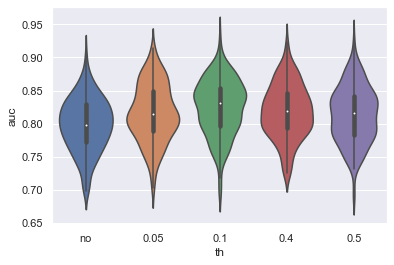

In [2623]:
ax = sns.violinplot(x='th', y='auc' ,data=test_all_record_8)

### Deviation_plot

In [1995]:
tmp = test_all_record_6.groupby(['embedding','qualified_nodes', 'strategy', 'graph_type', 'th','auc'])
count = 0
add_bench_mark_list = []
for i,j in tmp:
#     count +=1
#     print(j.shape[0])
#     print(i)
    emb = i[0]
#     graph_type = i[1]
    qualified_nodes = i[1]
    strategy = i[2]
    graph_type = i[3]
    th = i[4]
    auc = i[5]
#     graph_type = i[1]
#     qualified_nodes = i[2]
#     strategy = i[3]
#     count+=1
    new_count=0
    for b in bench_mark:
#         count +=1
#         print(b)
        dd = list(b.values())[:-1]

        emb_b = dd[2]
        graph_type_b = dd[4]
        qualified_nodes_b = dd[0]
        th_b = dd[5]
        classifier_b = dd[3]
        strategy_b = dd[1]
        bench_mark_val = dd[-1]
#         print(list(dd))
        
        if (emb_b == emb) and (graph_type == graph_type_b) \
                        and (qualified_nodes_b == qualified_nodes) \
                        and (strategy_b == 'no') \
                        and (th_b == th):
#         if (emb_b == emb) and (qualified_nodes_b == qualified_nodes) and (strategy_b == strategy):
            count+=1
            new_count+=1
#             print(bench_mark_val)
            add_bench_mark_val = {}
            add_bench_mark_val['th'] = th_b
            add_bench_mark_val['qualified_nodes'] = qualified_nodes_b
            add_bench_mark_val['embedding'] = emb_b
            add_bench_mark_val['strategy'] = strategy_b
            add_bench_mark_val['classifier'] = classifier_b
            add_bench_mark_val['graph_type'] = graph_type_b
            add_bench_mark_val['diff'] = auc-bench_mark_val
            add_bench_mark_list.append(add_bench_mark_val)
#     if new_count > 0:
#         print(new_count)
        
#             'th', 'qualified_nodes', 'embedding', 'strategy', 'classifier',
#        'graph_type', 'auc'
#         print()
#         print(len(b)) 
#         for k,v in b.items(): 
#             print(k)
#     print(j)
print(count)
print(add_bench_mark_list)

560
[{'th': '0.05', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': -0.04897540990247773}, {'th': '0.1', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': 0.04128999343103179}, {'th': '0.4', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': 0.15508202743150523}, {'th': '0.5', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': -0.0063572585192820386}, {'th': '0.05', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGDP', 'diff': 0.020452830118539267}, {'th': '0.1', 'qu

In [1995]:
tmp = test_all_record_6.groupby(['embedding','qualified_nodes', 'strategy', 'graph_type', 'th','auc'])
count = 0
add_bench_mark_list = []
for i,j in tmp:
#     count +=1
#     print(j.shape[0])
#     print(i)
    emb = i[0]
#     graph_type = i[1]
    qualified_nodes = i[1]
    strategy = i[2]
    graph_type = i[3]
    th = i[4]
    auc = i[5]
#     graph_type = i[1]
#     qualified_nodes = i[2]
#     strategy = i[3]
#     count+=1
    new_count=0
    for b in bench_mark:
#         count +=1
#         print(b)
        dd = list(b.values())[:-1]

        emb_b = dd[2]
        graph_type_b = dd[4]
        qualified_nodes_b = dd[0]
        th_b = dd[5]
        classifier_b = dd[3]
        strategy_b = dd[1]
        bench_mark_val = dd[-1]
#         print(list(dd))
        
        if (emb_b == emb) and (graph_type == graph_type_b) \
                        and (qualified_nodes_b == qualified_nodes) \
                        and (strategy_b == strategy) \
                        and (th_b == th):
#         if (emb_b == emb) and (qualified_nodes_b == qualified_nodes) and (strategy_b == strategy):
            count+=1
            new_count+=1
#             print(bench_mark_val)
            add_bench_mark_val = {}
            add_bench_mark_val['th'] = th_b
            add_bench_mark_val['qualified_nodes'] = qualified_nodes_b
            add_bench_mark_val['embedding'] = emb_b
            add_bench_mark_val['strategy'] = strategy_b
            add_bench_mark_val['classifier'] = classifier_b
            add_bench_mark_val['graph_type'] = graph_type_b
            add_bench_mark_val['diff'] = auc-bench_mark_val
            add_bench_mark_list.append(add_bench_mark_val)
#     if new_count > 0:
#         print(new_count)
        
#             'th', 'qualified_nodes', 'embedding', 'strategy', 'classifier',
#        'graph_type', 'auc'
#         print()
#         print(len(b)) 
#         for k,v in b.items(): 
#             print(k)
#     print(j)
print(count)
print(add_bench_mark_list)

560
[{'th': '0.05', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': -0.04897540990247773}, {'th': '0.1', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': 0.04128999343103179}, {'th': '0.4', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': 0.15508202743150523}, {'th': '0.5', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGD', 'diff': -0.0063572585192820386}, {'th': '0.05', 'qualified_nodes': 'SharedGeneAndPhenotypeEdges', 'embedding': 'GCN', 'strategy': 'bottom_k_deterministic', 'classifier': 'svm', 'graph_type': 'PGDP', 'diff': 0.020452830118539267}, {'th': '0.1', 'qu

In [2000]:
deviation_df = pd.DataFrame(add_bench_mark_list)

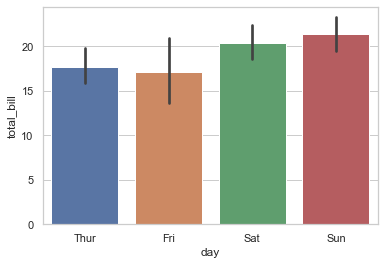

In [2013]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

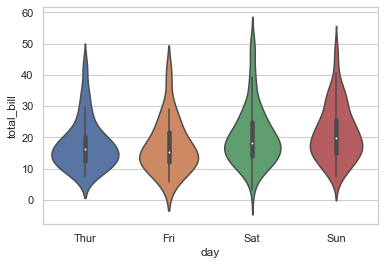

In [2018]:
ax = sns.violinplot(x="day", y="total_bill", data=tips)

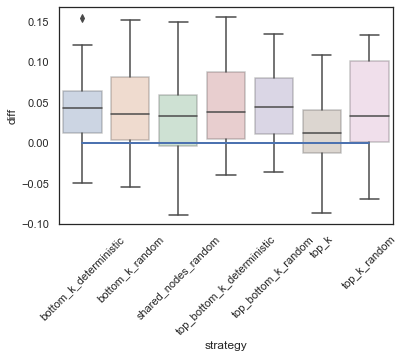

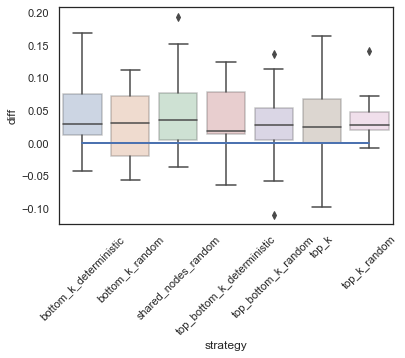

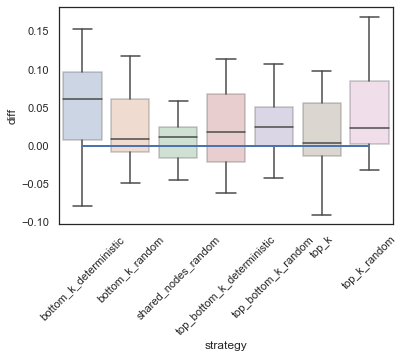

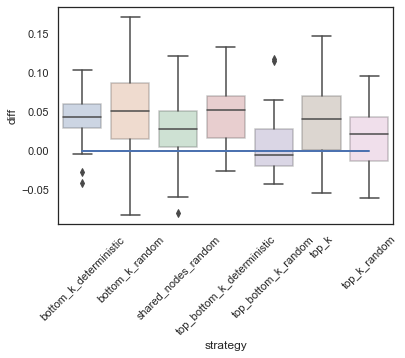

In [2063]:
tmp = deviation_df.groupby(['embedding','graph_type'])
for i,j in tmp:
#     print(j)
#     print(j.shape[0])
#     j['diff'].plot.bar()
#     j['diff'].plot(kind='bar',alpha=0.75, rot=45)
#     ax = sns.pointplot(x="strategy", y="diff", hue='qualified_nodes',data=j, join=False)
#     ax = sns.barplot(x="strategy", y="diff", hue='qualified_nodes',data=j)
    ax = sns.boxplot(x="strategy", y="diff",data=j, boxprops=dict(alpha=.3))
    plt.plot(np.zeros(7), linewidth=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    sns.despine(ax=b, left=True, bottom=True)
    plt.show()

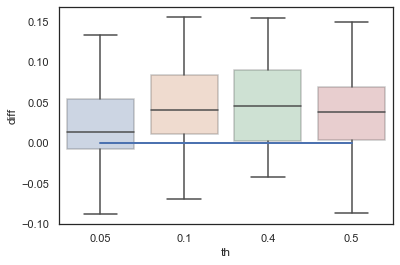

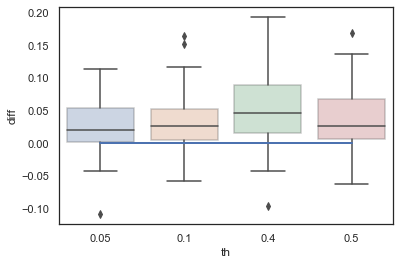

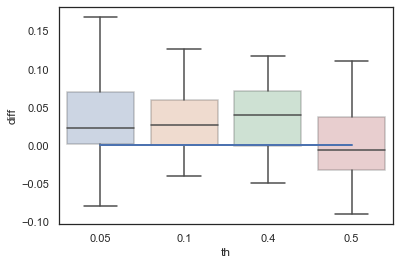

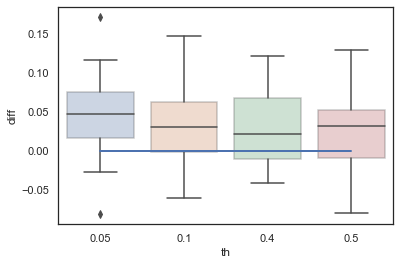

In [2064]:
tmp = deviation_df.groupby(['embedding','graph_type'])
for i,j in tmp:
#     print(j)
#     print(j.shape[0])
#     j['diff'].plot.bar()
#     j['diff'].plot(kind='bar',alpha=0.75, rot=45)
#     ax = sns.pointplot(x="strategy", y="diff", hue='qualified_nodes',data=j, join=False)
#     ax = sns.barplot(x="strategy", y="diff", hue='qualified_nodes',data=j)
    ax = sns.boxplot(x="th", y="diff",data=j, boxprops=dict(alpha=.3))
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)/
    plt.plot(np.zeros(4), linewidth=2)
    sns.despine(ax=b, left=True, bottom=True)
    plt.show()

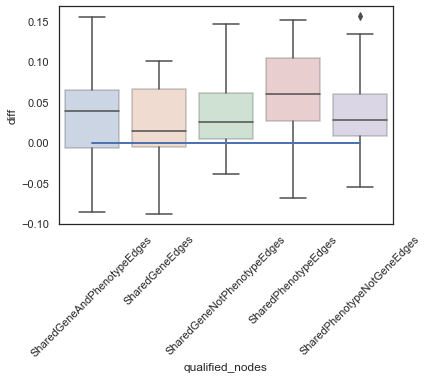

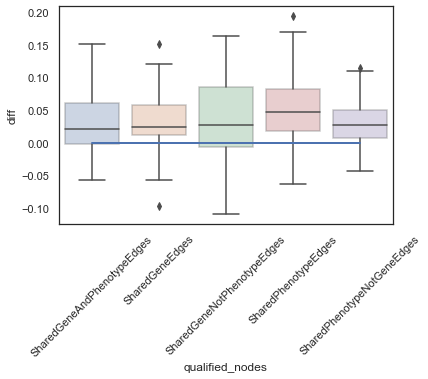

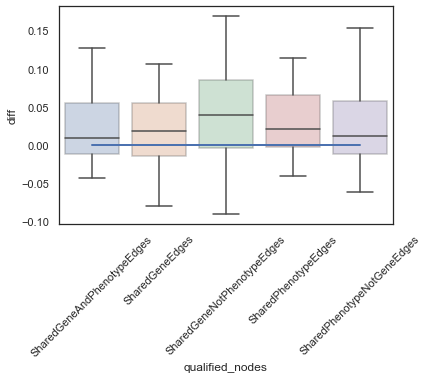

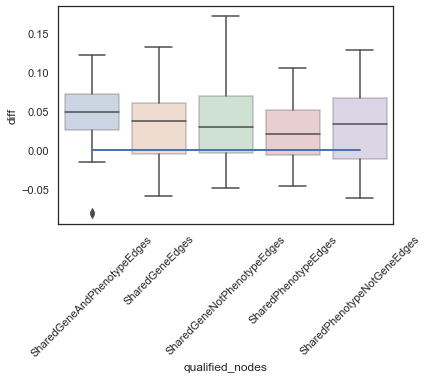

In [2066]:
tmp = deviation_df.groupby(['embedding','graph_type'])
for i,j in tmp:
#     print(j)
#     print(j.shape[0])
#     j['diff'].plot.bar()
#     j['diff'].plot(kind='bar',alpha=0.75, rot=45)
#     ax = sns.pointplot(x="strategy", y="diff", hue='qualified_nodes',data=j, join=False)
#     ax = sns.barplot(x="strategy", y="diff", hue='qualified_nodes',data=j)
    ax = sns.boxplot(x="qualified_nodes", y="diff",data=j, boxprops=dict(alpha=.3))
    ax.set_xticklabels(ax.get_xticklabels(), rotati/on=45)
    plt.plot(np.zeros(5), linewidth=2)
    sns.despine(ax=b, left=True, bottom=True)
    plt.show()

# plot ratio of better:worse then bench mark 

In [ ]:
col = ['top_bottom_k_deterministic', 'top_bottom_k_random', 
       'bottom_k_deterministic', 'bottom_k_random','top_k',
      'top_k_random','shared_nodes_random']
more_less = pd.DataFrame([more, less], columns = col, index=['better', 'worse'])
print(more_less)

import seaborn as sns
sns.set()
more_less.T.plot(kind='bar', stacked=True)

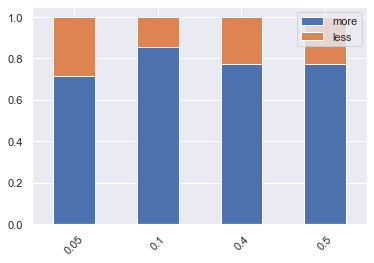

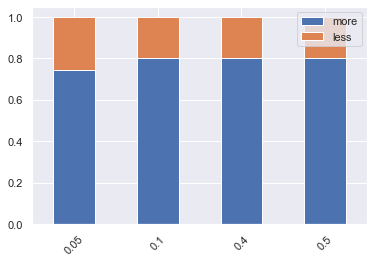

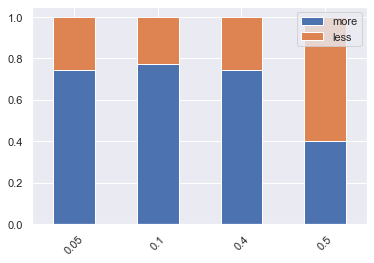

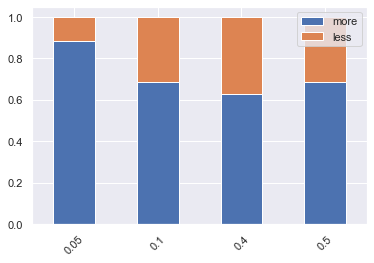

In [2111]:
tmp = deviation_df.groupby(['embedding','graph_type'])
for i,j in tmp:
#     print(j)
    tmp_1 = []
    for dd in get_unique_val(j,'th'):
        more = j[(j['diff'] > 0) & (j['th'] == dd)].shape[0]
        less = j[(j['diff'] < 0) & (j['th'] == dd)].shape[0]
        more_percent = more/j[j['th']==dd].shape[0]
        less_percent = less/j[j['th']==dd].shape[0]
        assert more_percent + less_percent == 1, ''
        tmp_1.append([more_percent,less_percent])
#     print(tmp_1)
    df = pd.DataFrame(np.array(tmp_1).T, columns=get_unique_val(j,'th'),index=['more','less'])
    sns.set()

    df.T.plot(kind='bar', stacked=True, rot=45)
#         print(more,less)


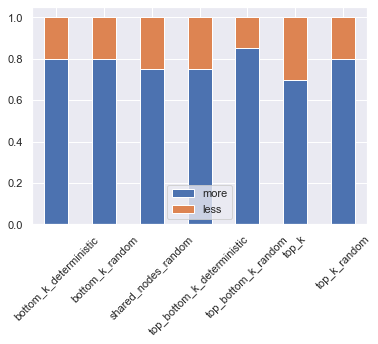

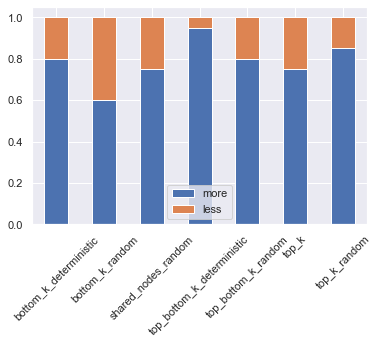

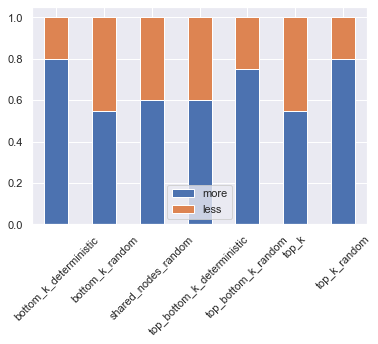

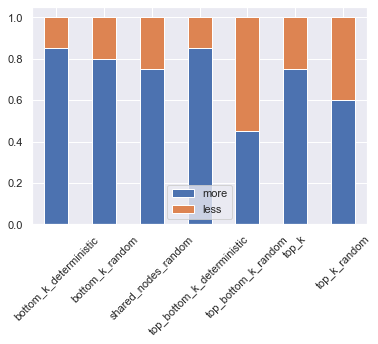

In [2112]:
tmp = deviation_df.groupby(['embedding','graph_type'])
block = 'strategy'
for i,j in tmp:
#     print(j)
    tmp_1 = []
    for dd in get_unique_val(j,block):
        more = j[(j['diff'] > 0) & (j[block] == dd)].shape[0]
        less = j[(j['diff'] < 0) & (j[block] == dd)].shape[0]
        more_percent = more/j[j[block]==dd].shape[0]
        less_percent = less/j[j[block]==dd].shape[0]
        assert more_percent + less_percent == 1, ''
        tmp_1.append([more_percent,less_percent])
#     print(tmp_1)
    df = pd.DataFrame(np.array(tmp_1).T, columns=get_unique_val(j,block),index=['more','less'])
    sns.set()

    df.T.plot(kind='bar', stacked=True, rot=45)
#         print(more,less)


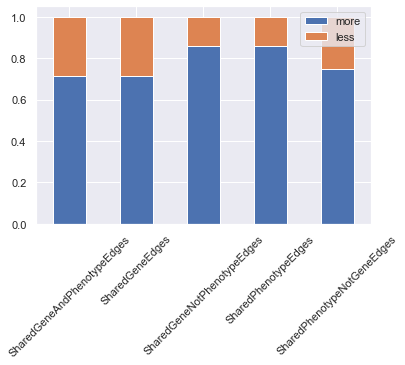

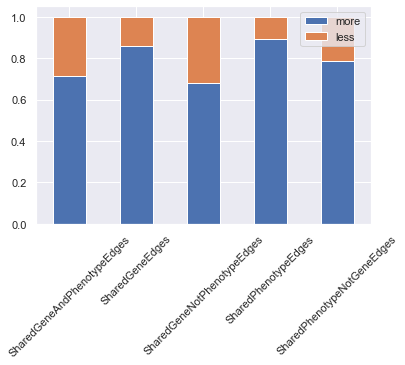

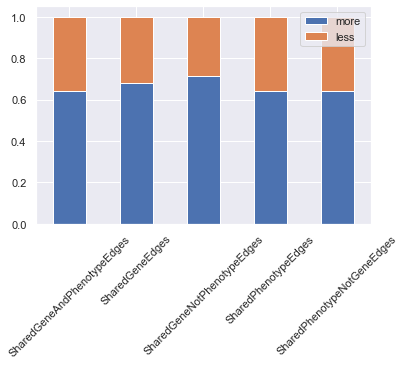

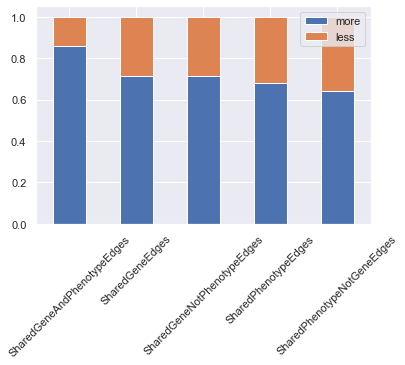

In [2114]:
tmp = deviation_df.groupby(['embedding','graph_type'])
block = 'qualified_nodes'
for i,j in tmp:
#     print(j)
    tmp_1 = []
    for dd in get_unique_val(j,block):
        more = j[(j['diff'] > 0) & (j[block] == dd)].shape[0]
        less = j[(j['diff'] < 0) & (j[block] == dd)].shape[0]
        more_percent = more/j[j[block]==dd].shape[0]
        less_percent = less/j[j[block]==dd].shape[0]
        assert more_percent + less_percent == 1, ''
        tmp_1.append([more_percent,less_percent])
#     print(tmp_1)
    df = pd.DataFrame(np.array(tmp_1).T, columns=get_unique_val(j,block),index=['more','less'])
    sns.set()

    df.T.plot(kind='bar', stacked=True, rot=45)
#         print(more,less)


In [311]:
def get_th(record_type,th, qualified_nodes):
    return record_type[(record_type['th'] == str(th)) & (record_type['qualified_nodes'] == qualified_nodes)]

def get_val_range(record_type):
    max_val = record_type['auc'].max()
    min_val = record_type['auc'].min()
    return min_val - 0.1, max_val+0.1


In [312]:
def get_unique_val(record_type,col):
    return record_type[col].unique()

### group = th

In [2540]:
block_list = ['th', 'qualified_nodes', 'strategy', 'embedding','graph_type']

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
--------for 0.05----
stat=20.152, p=0.000
Probably different distributions
--------for 0.1----
stat=32.114, p=0.000
Probably different distributions
--------for 0.4----
stat=23.581, p=0.000
Probably different distributions
--------for 0.5----
stat=23.581, p=0.000
Probably different distributions
--------for no----
stat=41.105, p=0.000
Probably different distributions
group = th and block = qualified_nodes
=======0.05==========
[58 55 31 32 34]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.         2.85714286 2.61904762 1.57142857 0.95238095]


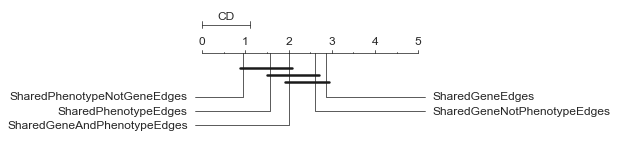

=======0.1==========
[40 47 50 42 31]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.04761905 3.42857143 2.57142857 1.47619048 1.47619048]


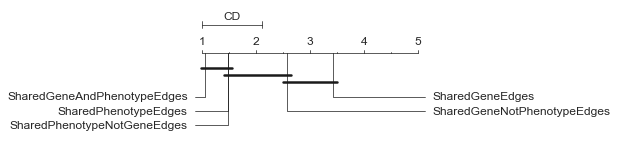

=======0.4==========
[30 40 46 50 44]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[0.71428571 2.47619048 2.95238095 2.         1.85714286]


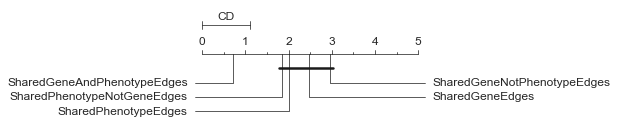

=======0.5==========
[46 41 49 34 40]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.38095238 2.71428571 3.04761905 1.14285714 1.71428571]


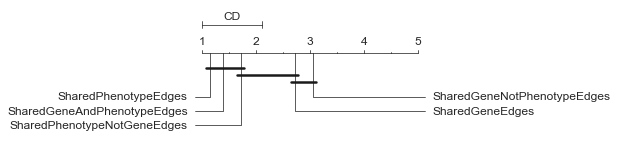

=======no==========
[61 43 35 36 35]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.57142857 3.0952381  3.23809524 0.76190476 1.33333333]


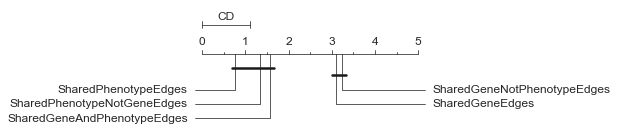

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
--------for 0.05----
stat=5.600, p=0.231
Probably the same distribution
--------for 0.1----
stat=6.362, p=0.174
Probably the same distribution
--------for 0.4----
stat=3.543, p=0.471
Probably the same distribution
--------for 0.5----
stat=9.410, p=0.052
Probably the same distribution
--------for no----
stat=28.914, p=0.000
Probably different distributions
group = th and block = qualified_nodes
=======0.05==========
[40 40 38 49 43]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.19047619 1.28571429 2.19047619 2.28571429 2.04761905]


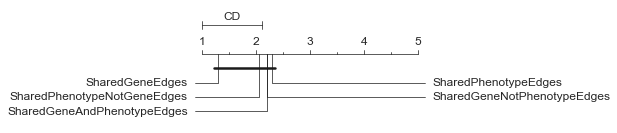

=======0.1==========
[33 55 30 48 44]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.80952381 1.95238095 1.71428571 2.76190476 1.76190476]


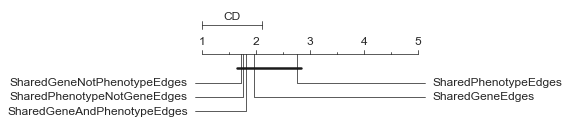

=======0.4==========
[40 36 40 43 51]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.61904762 1.76190476 2.42857143 2.         2.19047619]


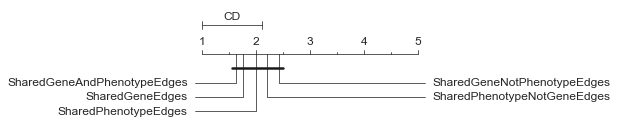

=======0.5==========
[35 48 41 54 32]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.9047619  2.61904762 1.52380952 1.47619048 2.47619048]


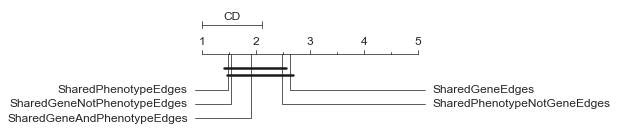

=======no==========
[19 42 46 50 53]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.61904762 1.         1.71428571 3.47619048 2.19047619]


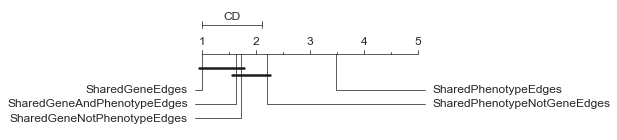

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
--------for 0.05----
stat=19.000, p=0.004
Probably different distributions
--------for 0.1----
stat=38.200, p=0.000
Probably different distributions
--------for 0.4----
stat=14.629, p=0.023
Probably different distributions
--------for 0.5----
stat=12.571, p=0.050
Probably the same distribution
--------for no----
stat=17.714, p=0.007
Probably different distributions
group = th and block = strategy
=======0.05==========
[32 56 48 52 40 35 52]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[1.8        3.6        3.66666667 3.4        3.66666667 1.33333333
 3.53333333]


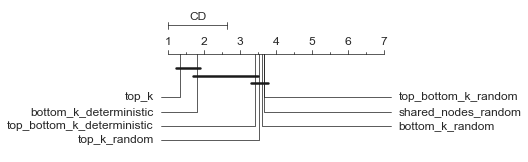

=======0.1==========
[35 38 45 48 56 48 45]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[0.73333333 4.66666667 3.6        2.93333333 3.2        1.6
 4.26666667]


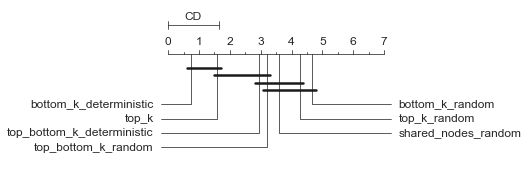

=======0.4==========
[52 49 34 45 40 55 40]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.93333333 3.06666667 2.26666667 4.73333333 3.         2.
 3.        ]


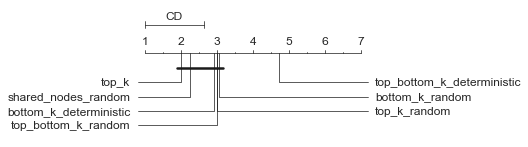

=======0.5==========
[56 41 35 48 53 42 40]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.86666667 3.53333333 3.53333333 3.13333333 2.46666667 1.53333333
 3.93333333]


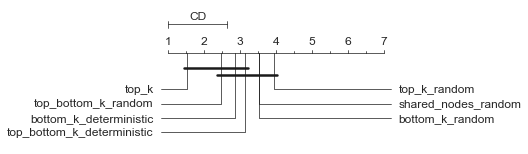

=======no==========
[30 48 44 42 50 40 61]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.66666667 1.33333333 2.33333333 3.2        2.8        4.26666667
 3.4       ]


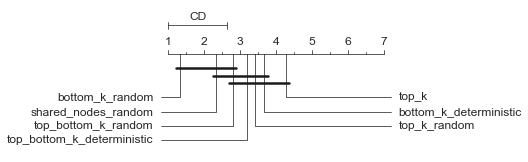

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
--------for 0.05----
stat=16.143, p=0.013
Probably different distributions
--------for 0.1----
stat=10.029, p=0.123
Probably the same distribution
--------for 0.4----
stat=9.400, p=0.152
Probably the same distribution
--------for 0.5----
stat=8.971, p=0.175
Probably the same distribution
--------for no----
stat=16.286, p=0.012
Probably different distributions
group = th and block = strategy
=======0.05==========
[28 56 52 46 37 59 37]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.73333333 1.2        3.6        2.86666667 3.33333333 3.73333333
 2.53333333]


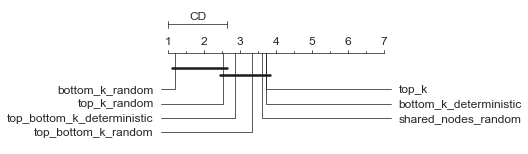

=======0.1==========
[45 35 46 38 59 46 46]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.         3.26666667 2.06666667 2.2        3.6        4.06666667
 2.8       ]


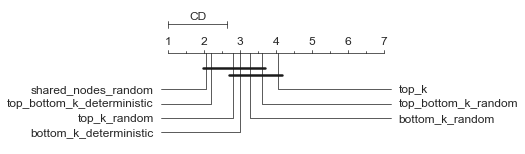

=======0.4==========
[32 51 49 42 50 43 48]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.46666667 3.33333333 2.4        3.8        2.2        3.93333333
 2.86666667]


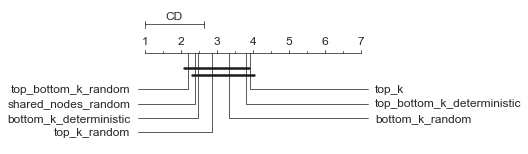

=======0.5==========
[55 57 42 42 35 46 38]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.06666667 3.73333333 3.33333333 3.73333333 1.93333333 2.86666667
 2.33333333]


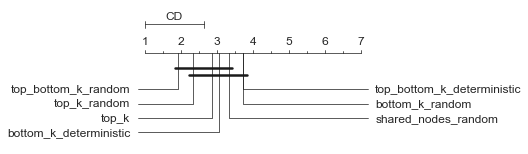

=======no==========
[36 40 50 27 45 41 76]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.86666667 2.33333333 2.13333333 3.         3.06666667 2.66666667
 4.93333333]


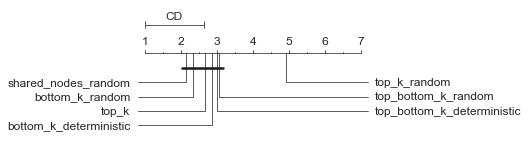

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
--------for 0.05----
stat=9.829, p=0.007
Probably different distributions
--------for 0.1----
stat=11.029, p=0.004
Probably different distributions
--------for 0.4----
stat=5.314, p=0.070
Probably the same distribution
--------for 0.5----
stat=17.543, p=0.000
Probably different distributions
--------for no----
stat=8.629, p=0.013
Probably different distributions
group = th and block = graph_type
=======0.05==========
[52 27 26]
['GD', 'PGD', 'PGDP']
[1.4        0.94285714 0.65714286]


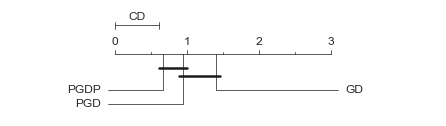

=======0.1==========
[47 34 24]
['GD', 'PGD', 'PGDP']
[1.45714286 0.74285714 0.8       ]


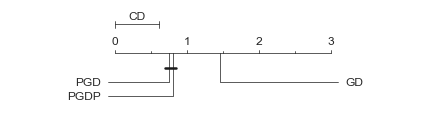

=======0.4==========
[49 22 34]
['GD', 'PGD', 'PGDP']
[1.31428571 0.8        0.88571429]


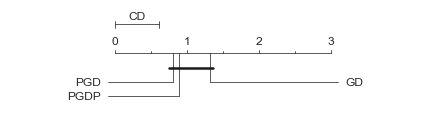

=======0.5==========
[59 22 24]
['GD', 'PGD', 'PGDP']
[1.48571429 1.02857143 0.48571429]


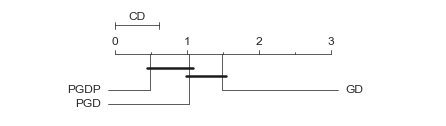

=======no==========
[48 28 29]
['GD', 'PGD', 'PGDP']
[1.4        0.74285714 0.85714286]


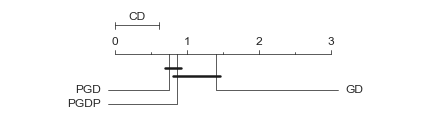

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
--------for 0.05----
stat=15.600, p=0.000
Probably different distributions
--------for 0.1----
stat=19.943, p=0.000
Probably different distributions
--------for 0.4----
stat=8.457, p=0.015
Probably different distributions
--------for 0.5----
stat=11.486, p=0.003
Probably different distributions
--------for no----
stat=2.057, p=0.358
Probably the same distribution
group = th and block = graph_type
=======0.05==========
[52 31 22]
['GD', 'PGD', 'PGDP']
[1.54285714 0.77142857 0.68571429]


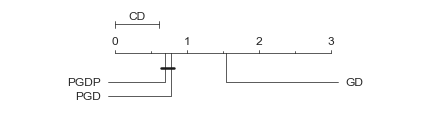

=======0.1==========
[48 32 25]
['GD', 'PGD', 'PGDP']
[1.57142857 0.51428571 0.91428571]


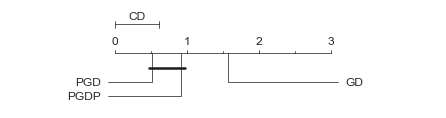

=======0.4==========
[51 25 29]
['GD', 'PGD', 'PGDP']
[1.4        0.82857143 0.77142857]


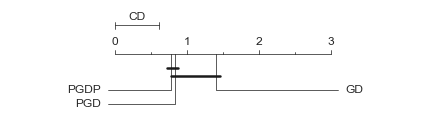

=======0.5==========
[52 22 31]
['GD', 'PGD', 'PGDP']
[1.45714286 0.68571429 0.85714286]


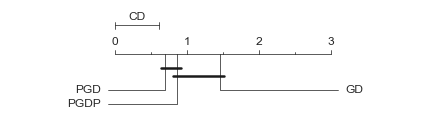

=======no==========
[45 21 39]
['GD', 'PGD', 'PGDP']
[1.17142857 0.82857143 1.        ]


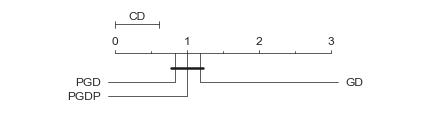

In [2592]:

embedding_types = ['Node2Vec', 'GCN']
group = 'th'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
                run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
            run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            

>>>>>>>>>>>>>>>>>>>>>>(gruop=th, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = qualified_nodes
--------for 0.05----
stat=7.276, p=0.122
Probably the same distribution
--------for 0.1----
stat=16.514, p=0.002
Probably different distributions
--------for 0.4----
stat=19.924, p=0.001
Probably different distributions
--------for 0.5----
stat=19.143, p=0.001
Probably different distributions
--------for no----
stat=7.790, p=0.100
Probably the same distribution
group = th and block = qualified_nodes
=======0.05==========
[98 95 69 81 77]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.0952381  2.07142857 2.4047619  1.92857143 1.5       ]


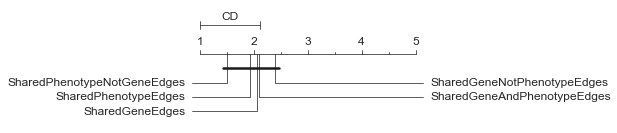

=======0.1==========
[ 73 102  80  90  75]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.42857143 2.69047619 2.14285714 2.11904762 1.61904762]


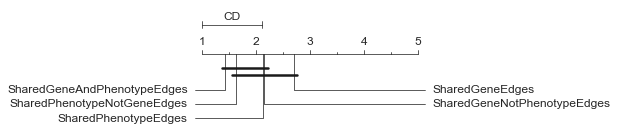

=======0.4==========
[70 76 86 93 95]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.16666667 2.11904762 2.69047619 2.         2.02380952]


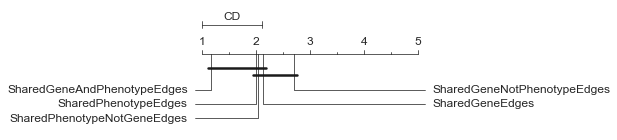

=======0.5==========
[81 89 90 88 72]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.64285714 2.66666667 2.28571429 1.30952381 2.0952381 ]


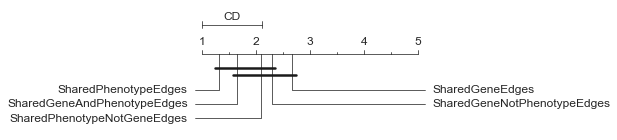

=======no==========
[80 85 81 86 88]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.5952381  2.04761905 2.47619048 2.11904762 1.76190476]


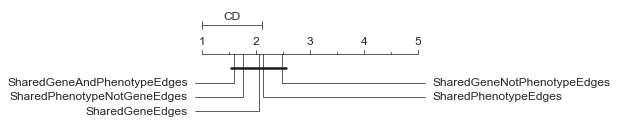

>>>>>>>>>>>>>>>>>>>>>>(gruop=th, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = strategy
--------for 0.05----
stat=8.371, p=0.212
Probably the same distribution
--------for 0.1----
stat=18.686, p=0.005
Probably different distributions
--------for 0.4----
stat=15.071, p=0.020
Probably different distributions
--------for 0.5----
stat=13.343, p=0.038
Probably different distributions
--------for no----
stat=23.229, p=0.001
Probably different distributions
group = th and block = strategy
=======0.05==========
[ 60 112 100  98  77  94  89]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.76666667 2.4        3.63333333 3.13333333 3.5        2.53333333
 3.03333333]


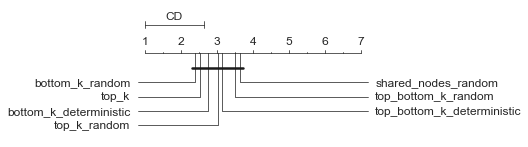

=======0.1==========
[ 80  73  91  86 115  94  91]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[1.86666667 3.96666667 2.83333333 2.56666667 3.4        2.83333333
 3.53333333]


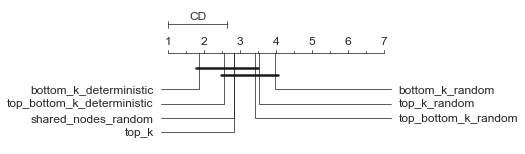

=======0.4==========
[ 84 100  83  87  90  98  88]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.7        3.2        2.33333333 4.26666667 2.6        2.96666667
 2.93333333]


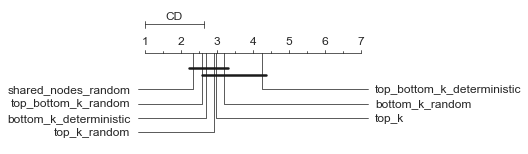

=======0.5==========
[111  98  77  90  88  88  78]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.96666667 3.63333333 3.43333333 3.43333333 2.2        2.2
 3.13333333]


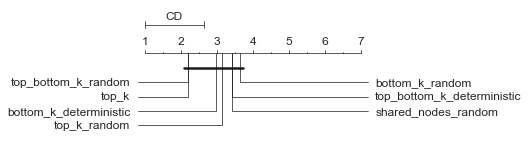

=======no==========
[ 66  88  94  69  95  81 137]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.26666667 1.83333333 2.23333333 3.1        2.93333333 3.46666667
 4.16666667]


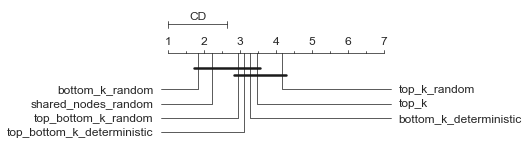

>>>>>>>>>>>>>>>>>>>>>>(gruop=th, block=embedding)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = embedding
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = th and block = embedding
=======0.05==========
[69 36]
['GCN', 'Node2Vec']
[0.65714286 0.34285714]


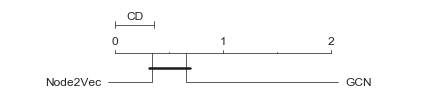

=======0.1==========
[48 57]
['GCN', 'Node2Vec']
[0.45714286 0.54285714]


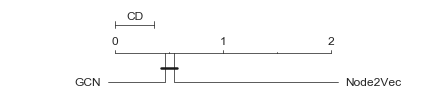

=======0.4==========
[50 55]
['GCN', 'Node2Vec']
[0.47619048 0.52380952]


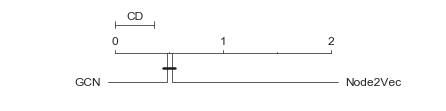

=======0.5==========
[26 79]
['GCN', 'Node2Vec']
[0.24761905 0.75238095]


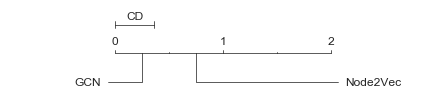

=======no==========
[43 62]
['GCN', 'Node2Vec']
[0.40952381 0.59047619]


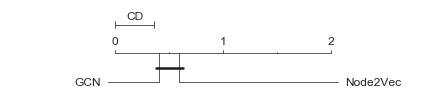

>>>>>>>>>>>>>>>>>>>>>>(gruop=th, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = th and block = graph_type
--------for 0.05----
stat=24.543, p=0.000
Probably different distributions
--------for 0.1----
stat=29.600, p=0.000
Probably different distributions
--------for 0.4----
stat=13.400, p=0.001
Probably different distributions
--------for 0.5----
stat=24.543, p=0.000
Probably different distributions
--------for no----
stat=9.286, p=0.010
Probably different distributions
group = th and block = graph_type
=======0.05==========
[104  58  48]
['GD', 'PGD', 'PGDP']
[1.47142857 0.85714286 0.67142857]


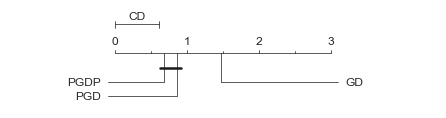

=======0.1==========
[95 66 49]
['GD', 'PGD', 'PGDP']
[1.51428571 0.62857143 0.85714286]


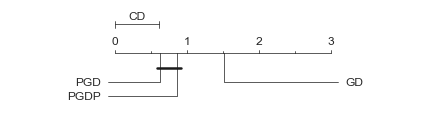

=======0.4==========
[100  47  63]
['GD', 'PGD', 'PGDP']
[1.35714286 0.81428571 0.82857143]


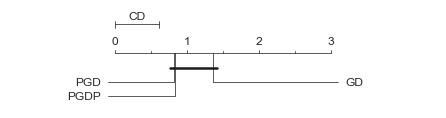

=======0.5==========
[111  44  55]
['GD', 'PGD', 'PGDP']
[1.47142857 0.85714286 0.67142857]


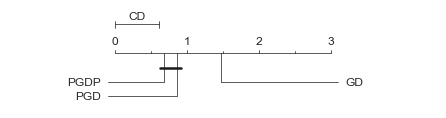

=======no==========
[93 49 68]
['GD', 'PGD', 'PGDP']
[1.28571429 0.78571429 0.92857143]


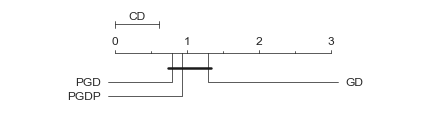

In [2595]:
group = 'th'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )


### group = qualified_nodes

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = th
--------for SharedGeneAndPhenotypeEdges----
stat=14.590, p=0.006
Probably different distributions
--------for SharedGeneEdges----
stat=17.524, p=0.002
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=19.695, p=0.001
Probably different distributions
--------for SharedPhenotypeEdges----
stat=10.210, p=0.037
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=6.971, p=0.137
Probably the same distribution
group = qualified_nodes and block = th
=======SharedGeneAndPhenotypeEdges==========
[32 26 47 45 60]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.66666667 1.42857143 1.61904762 2.23809524 3.04761905]


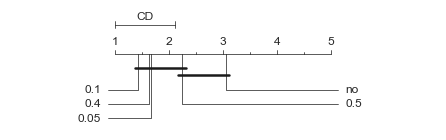

=======SharedGeneEdges==========
[30 30 42 51 57]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.47619048 1.9047619  1.38095238 2.04761905 3.19047619]


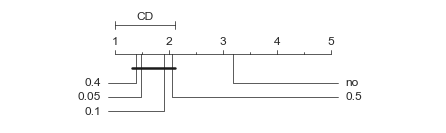

=======SharedGeneNotPhenotypeEdges==========
[26 28 43 50 63]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.38095238 1.14285714 2.         2.47619048 3.        ]


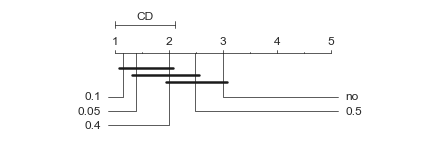

=======SharedPhenotypeEdges==========
[32 43 38 47 50]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.14285714 2.         2.57142857 2.38095238 1.9047619 ]


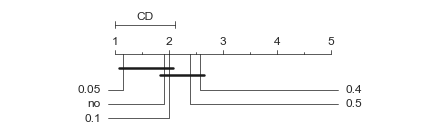

=======SharedPhenotypeNotGeneEdges==========
[38 34 30 51 57]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.33333333 1.71428571 2.28571429 2.33333333 2.33333333]


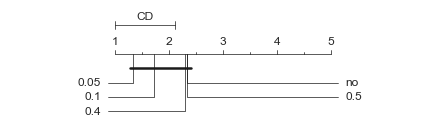

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = th
--------for SharedGeneAndPhenotypeEdges----
stat=11.924, p=0.018
Probably different distributions
--------for SharedGeneEdges----
stat=2.133, p=0.711
Probably the same distribution
--------for SharedGeneNotPhenotypeEdges----
stat=8.495, p=0.075
Probably the same distribution
--------for SharedPhenotypeEdges----
stat=26.667, p=0.000
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=11.695, p=0.020
Probably different distributions
group = qualified_nodes and block = th
=======SharedGeneAndPhenotypeEdges==========
[42 35 58 39 36]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.80952381 1.42857143 1.42857143 2.         2.33333333]


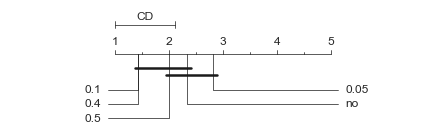

=======SharedGeneEdges==========
[37 44 40 47 42]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.85714286 2.0952381  1.66666667 2.33333333 2.04761905]


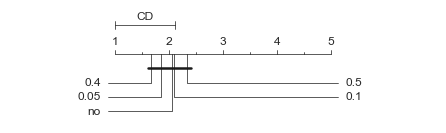

=======SharedGeneNotPhenotypeEdges==========
[37 45 55 38 35]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.47619048 1.33333333 2.47619048 1.66666667 2.04761905]


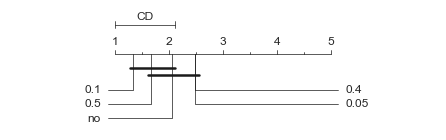

=======SharedPhenotypeEdges==========
[48 33 24 50 55]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.23809524 1.9047619  1.38095238 1.0952381  3.38095238]


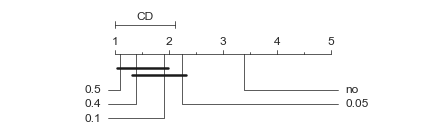

=======SharedPhenotypeNotGeneEdges==========
[30 46 39 51 44]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.23809524 1.0952381  2.19047619 1.80952381 2.66666667]


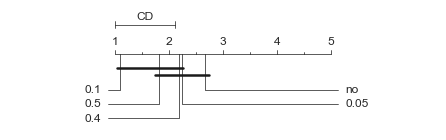

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = strategy
--------for SharedGeneAndPhenotypeEdges----
stat=9.400, p=0.152
Probably the same distribution
--------for SharedGeneEdges----
stat=14.086, p=0.029
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=18.714, p=0.005
Probably different distributions
--------for SharedPhenotypeEdges----
stat=13.286, p=0.039
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=12.971, p=0.043
Probably different distributions
group = qualified_nodes and block = strategy
=======SharedGeneAndPhenotypeEdges==========
[35 47 50 52 62 47 22]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.46666667 3.2        4.2        3.         3.13333333 1.93333333
 3.06666667]


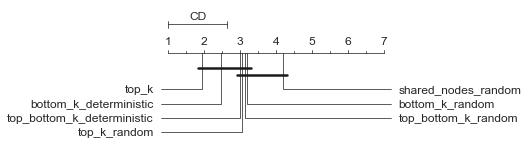

=======SharedGeneEdges==========
[30 53 49 28 54 39 62]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.46666667 2.6        3.13333333 3.6        2.4        2.2
 4.6       ]


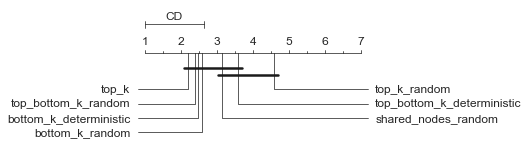

=======SharedGeneNotPhenotypeEdges==========
[59 45 32 42 33 51 53]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.33333333 3.93333333 2.4        3.8        3.66666667 1.33333333
 3.53333333]


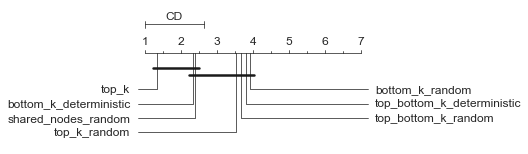

=======SharedPhenotypeEdges==========
[32 50 45 56 39 47 46]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.13333333 3.66666667 3.33333333 3.4        1.53333333 3.26666667
 3.66666667]


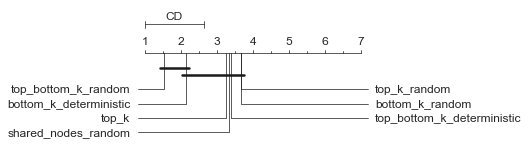

=======SharedPhenotypeNotGeneEdges==========
[49 37 30 57 51 36 55]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.6        2.8        2.33333333 3.6        4.4        2.
 3.26666667]


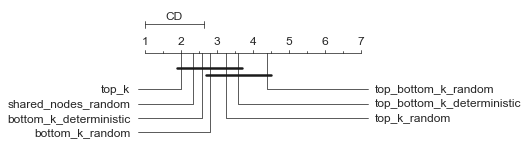

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = strategy
--------for SharedGeneAndPhenotypeEdges----
stat=18.143, p=0.006
Probably different distributions
--------for SharedGeneEdges----
stat=11.829, p=0.066
Probably the same distribution
--------for SharedGeneNotPhenotypeEdges----
stat=7.771, p=0.255
Probably the same distribution
--------for SharedPhenotypeEdges----
stat=9.629, p=0.141
Probably the same distribution
--------for SharedPhenotypeNotGeneEdges----
stat=3.686, p=0.719
Probably the same distribution
group = qualified_nodes and block = strategy
=======SharedGeneAndPhenotypeEdges==========
[34 44 41 39 49 42 66]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.93333333 2.2        1.6        3.66666667 2.86666667 4.6
 3.13333333]


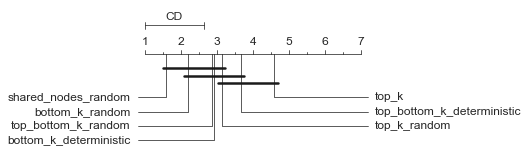

=======SharedGeneEdges==========
[29 41 64 43 51 41 46]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.13333333 1.46666667 3.8        2.93333333 3.33333333 3.66666667
 2.66666667]


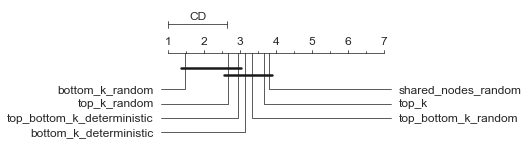

=======SharedGeneNotPhenotypeEdges==========
[36 34 54 48 45 60 38]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[1.73333333 3.66666667 3.06666667 3.2        2.8        3.53333333
 3.        ]


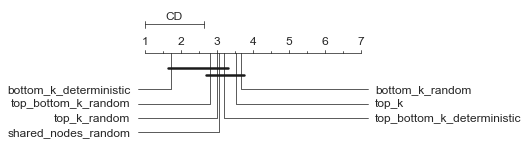

=======SharedPhenotypeEdges==========
[45 59 44 40 40 37 50]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[4.13333333 3.06666667 2.66666667 2.4        2.06666667 3.06666667
 3.6       ]


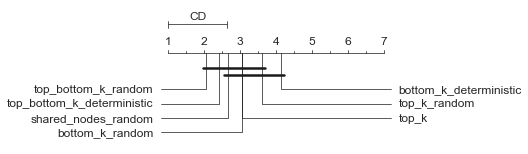

=======SharedPhenotypeNotGeneEdges==========
[52 61 36 25 41 55 45]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.2        3.46666667 2.4        3.4        3.06666667 2.4
 3.06666667]


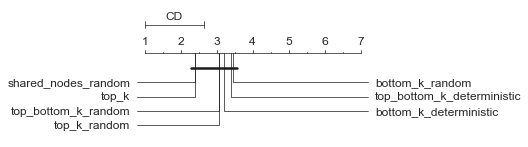

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=qualified_nodes, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = graph_type
--------for SharedGeneAndPhenotypeEdges----
stat=13.086, p=0.001
Probably different distributions
--------for SharedGeneEdges----
stat=6.686, p=0.035
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=18.914, p=0.000
Probably different distributions
--------for SharedPhenotypeEdges----
stat=6.343, p=0.042
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=11.029, p=0.004
Probably different distributions
group = qualified_nodes and block = graph_type
=======SharedGeneAndPhenotypeEdges==========
[56 22 27]
['GD', 'PGD', 'PGDP']
[1.34285714 1.14285714 0.51428571]


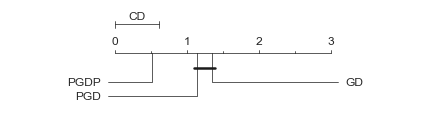

=======SharedGeneEdges==========
[51 24 30]
['GD', 'PGD', 'PGDP']
[1.34285714 0.91428571 0.74285714]


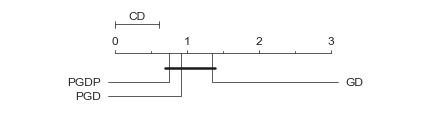

=======SharedGeneNotPhenotypeEdges==========
[52 32 21]
['GD', 'PGD', 'PGDP']
[1.6        0.68571429 0.71428571]


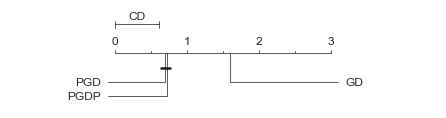

=======SharedPhenotypeEdges==========
[44 29 32]
['GD', 'PGD', 'PGDP']
[1.31428571 0.71428571 0.97142857]


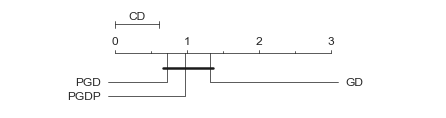

=======SharedPhenotypeNotGeneEdges==========
[52 26 27]
['GD', 'PGD', 'PGDP']
[1.45714286 0.8        0.74285714]


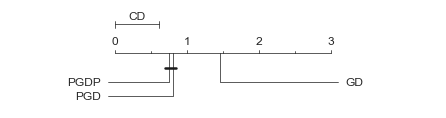

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=qualified_nodes, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = graph_type
--------for SharedGeneAndPhenotypeEdges----
stat=17.200, p=0.000
Probably different distributions
--------for SharedGeneEdges----
stat=7.086, p=0.029
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=13.943, p=0.001
Probably different distributions
--------for SharedPhenotypeEdges----
stat=5.714, p=0.057
Probably the same distribution
--------for SharedPhenotypeNotGeneEdges----
stat=12.400, p=0.002
Probably different distributions
group = qualified_nodes and block = graph_type
=======SharedGeneAndPhenotypeEdges==========
[47 34 24]
['GD', 'PGD', 'PGDP']
[1.54285714 0.57142857 0.88571429]


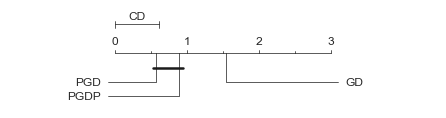

=======SharedGeneEdges==========
[54 19 32]
['GD', 'PGD', 'PGDP']
[1.34285714 0.94285714 0.71428571]


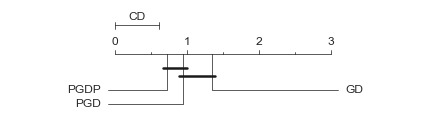

=======SharedGeneNotPhenotypeEdges==========
[51 31 23]
['GD', 'PGD', 'PGDP']
[1.51428571 0.77142857 0.71428571]


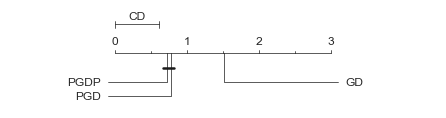

=======SharedPhenotypeEdges==========
[46 23 36]
['GD', 'PGD', 'PGDP']
[1.28571429 0.71428571 1.        ]


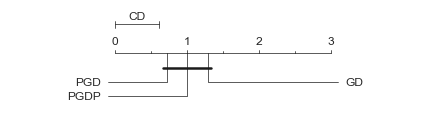

=======SharedPhenotypeNotGeneEdges==========
[50 24 31]
['GD', 'PGD', 'PGDP']
[1.45714286 0.62857143 0.91428571]


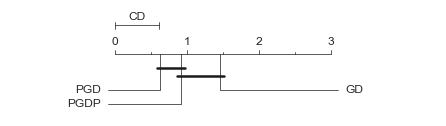

In [2596]:

embedding_types = ['Node2Vec', 'GCN']
group = 'qualified_nodes'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
                run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
            run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            

>>>>>>>>>>>>>>>>>>>>>>(gruop=qualified_nodes, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = th
--------for SharedGeneAndPhenotypeEdges----
stat=18.495, p=0.001
Probably different distributions
--------for SharedGeneEdges----
stat=12.724, p=0.013
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=15.486, p=0.004
Probably different distributions
--------for SharedPhenotypeEdges----
stat=9.752, p=0.045
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=11.962, p=0.018
Probably different distributions
group = qualified_nodes and block = th
=======SharedGeneAndPhenotypeEdges==========
[ 74  61 105  84  96]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.23809524 1.42857143 1.52380952 2.11904762 2.69047619]


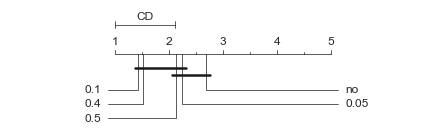

=======SharedGeneEdges==========
[67 74 82 98 99]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.66666667 2.         1.52380952 2.19047619 2.61904762]


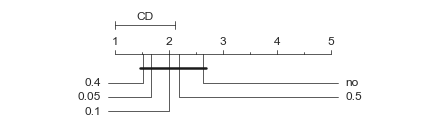

=======SharedGeneNotPhenotypeEdges==========
[63 73 98 88 98]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.92857143 1.23809524 2.23809524 2.07142857 2.52380952]


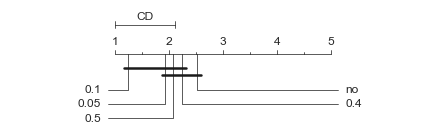

=======SharedPhenotypeEdges==========
[ 80  76  62  97 105]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.69047619 1.95238095 1.97619048 1.73809524 2.64285714]


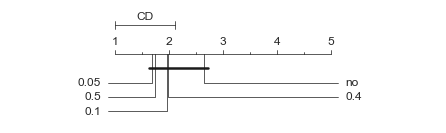

=======SharedPhenotypeNotGeneEdges==========
[ 68  80  69 102 101]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.78571429 1.4047619  2.23809524 2.07142857 2.5       ]


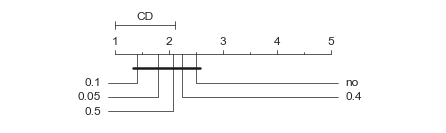

>>>>>>>>>>>>>>>>>>>>>>(gruop=qualified_nodes, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = strategy
--------for SharedGeneAndPhenotypeEdges----
stat=2.457, p=0.873
Probably the same distribution
--------for SharedGeneEdges----
stat=10.843, p=0.093
Probably the same distribution
--------for SharedGeneNotPhenotypeEdges----
stat=15.057, p=0.020
Probably different distributions
--------for SharedPhenotypeEdges----
stat=13.057, p=0.042
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=12.114, p=0.059
Probably the same distribution
group = qualified_nodes and block = strategy
=======SharedGeneAndPhenotypeEdges==========
[ 69  91  91  91 111  89  88]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.7        2.7        2.9        3.33333333 3.         3.26666667
 3.1       ]


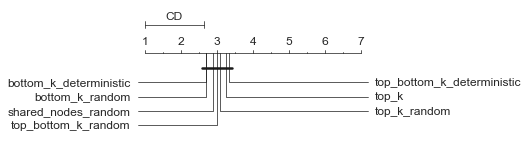

=======SharedGeneEdges==========
[ 59  94 113  71 105  80 108]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.8        2.03333333 3.46666667 3.26666667 2.86666667 2.93333333
 3.63333333]


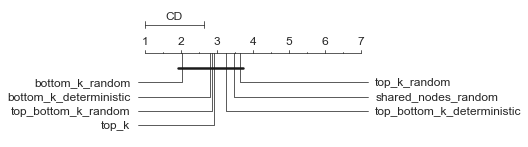

=======SharedGeneNotPhenotypeEdges==========
[ 95  79  86  90  78 111  91]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.03333333 3.8        2.73333333 3.5        3.23333333 2.43333333
 3.26666667]


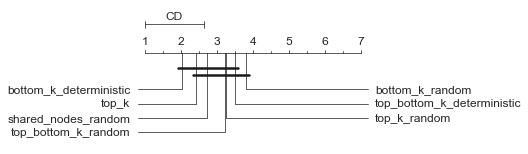

=======SharedPhenotypeEdges==========
[ 77 109  89  96  79  84  96]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.13333333 3.36666667 3.         2.9        1.8        3.16666667
 3.63333333]


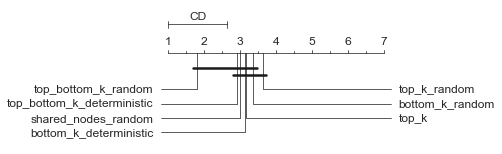

=======SharedPhenotypeNotGeneEdges==========
[101  98  66  82  92  91 100]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.9        3.13333333 2.36666667 3.5        3.73333333 2.2
 3.16666667]


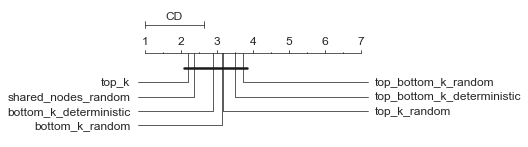

>>>>>>>>>>>>>>>>>>>>>>(gruop=qualified_nodes, block=embedding)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = embedding
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = qualified_nodes and block = embedding
=======SharedGeneAndPhenotypeEdges==========
[56 49]
['GCN', 'Node2Vec']
[0.53333333 0.46666667]


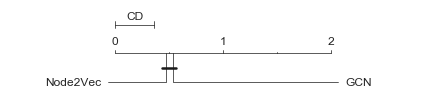

=======SharedGeneEdges==========
[22 83]
['GCN', 'Node2Vec']
[0.20952381 0.79047619]


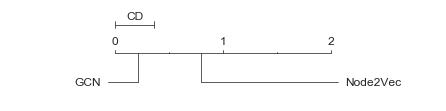

=======SharedGeneNotPhenotypeEdges==========
[29 76]
['GCN', 'Node2Vec']
[0.27619048 0.72380952]


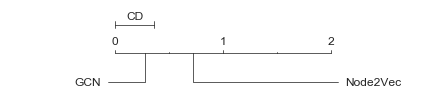

=======SharedPhenotypeEdges==========
[64 41]
['GCN', 'Node2Vec']
[0.60952381 0.39047619]


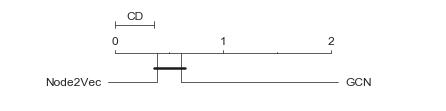

=======SharedPhenotypeNotGeneEdges==========
[65 40]
['GCN', 'Node2Vec']
[0.61904762 0.38095238]


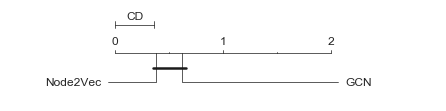

>>>>>>>>>>>>>>>>>>>>>>(gruop=qualified_nodes, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = qualified_nodes and block = graph_type
--------for SharedGeneAndPhenotypeEdges----
stat=21.457, p=0.000
Probably different distributions
--------for SharedGeneEdges----
stat=13.743, p=0.001
Probably different distributions
--------for SharedGeneNotPhenotypeEdges----
stat=32.600, p=0.000
Probably different distributions
--------for SharedPhenotypeEdges----
stat=12.029, p=0.002
Probably different distributions
--------for SharedPhenotypeNotGeneEdges----
stat=22.400, p=0.000
Probably different distributions
group = qualified_nodes and block = graph_type
=======SharedGeneAndPhenotypeEdges==========
[103  56  51]
['GD', 'PGD', 'PGDP']
[1.44285714 0.85714286 0.7       ]


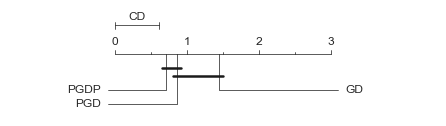

=======SharedGeneEdges==========
[105  43  62]
['GD', 'PGD', 'PGDP']
[1.34285714 0.92857143 0.72857143]


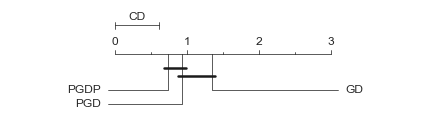

=======SharedGeneNotPhenotypeEdges==========
[103  63  44]
['GD', 'PGD', 'PGDP']
[1.55714286 0.72857143 0.71428571]


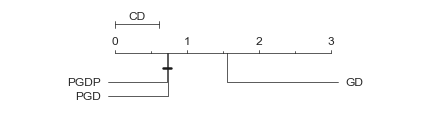

=======SharedPhenotypeEdges==========
[90 52 68]
['GD', 'PGD', 'PGDP']
[1.3        0.71428571 0.98571429]


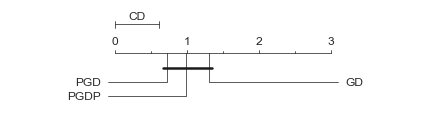

=======SharedPhenotypeNotGeneEdges==========
[102  50  58]
['GD', 'PGD', 'PGDP']
[1.45714286 0.71428571 0.82857143]


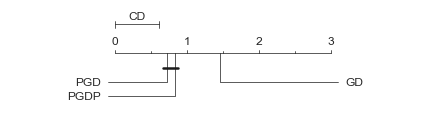

In [2598]:
group = 'qualified_nodes'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )
            

### group = strategy

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = th
--------for bottom_k_deterministic----
stat=26.827, p=0.000
Probably different distributions
--------for bottom_k_random----
stat=7.413, p=0.116
Probably the same distribution
--------for shared_nodes_random----
stat=6.507, p=0.164
Probably the same distribution
--------for top_bottom_k_deterministic----
stat=12.853, p=0.012
Probably different distributions
--------for top_bottom_k_random----
stat=8.373, p=0.079
Probably the same distribution
--------for top_k----
stat=23.093, p=0.000
Probably different distributions
--------for top_k_random----
stat=4.747, p=0.314
Probably the same distribution
group = strategy and block = th
=======bottom_k_deterministic==========
[15 16 25 51 43]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.26666667 0.66666667 2.13333333 2.6        3.33333333]


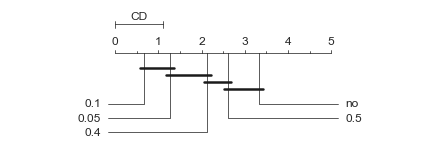

=======bottom_k_random==========
[28 35 30 27 30]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.6        2.6        1.73333333 2.6        1.46666667]


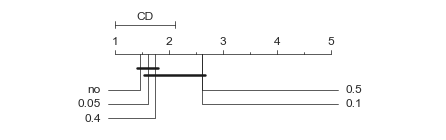

=======shared_nodes_random==========
[34 13 33 31 39]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.53333333 1.93333333 1.66666667 2.86666667 2.        ]


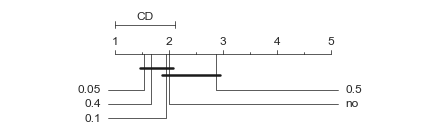

=======top_bottom_k_deterministic==========
[22 19 28 41 40]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.33333333 1.26666667 2.53333333 1.93333333 2.93333333]


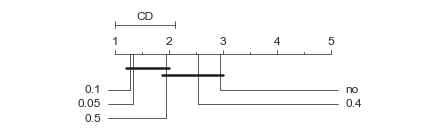

=======top_bottom_k_random==========
[19 33 28 29 41]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.6        1.73333333 2.06666667 1.6        3.        ]


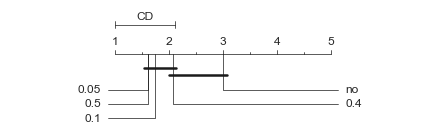

=======top_k==========
[16 18 31 33 52]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.06666667 1.4        1.8        2.13333333 3.6       ]


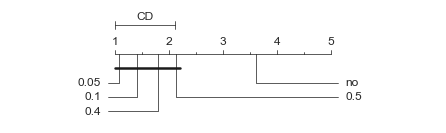

=======top_k_random==========
[24 27 25 32 42]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.4        1.86666667 1.86666667 2.33333333 2.53333333]


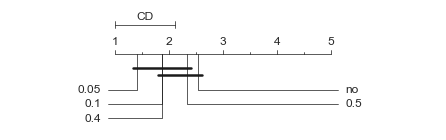

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = th
--------for bottom_k_deterministic----
stat=7.627, p=0.106
Probably the same distribution
--------for bottom_k_random----
stat=8.053, p=0.090
Probably the same distribution
--------for shared_nodes_random----
stat=13.067, p=0.011
Probably different distributions
--------for top_bottom_k_deterministic----
stat=7.307, p=0.121
Probably the same distribution
--------for top_bottom_k_random----
stat=13.280, p=0.010
Probably different distributions
--------for top_k----
stat=7.573, p=0.109
Probably the same distribution
--------for top_k_random----
stat=20.747, p=0.000
Probably different distributions
group = strategy and block = th
=======bottom_k_deterministic==========
[26 30 40 40 14]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.86666667 1.46666667 1.53333333 2.         2.13333333]


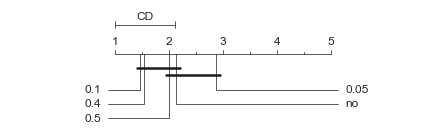

=======bottom_k_random==========
[15 32 33 31 39]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.06666667 2.         2.         2.6        2.33333333]


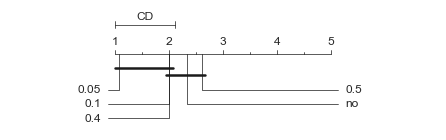

=======shared_nodes_random==========
[33 21 40 36 20]
['0.05', '0.1', '0.4', '0.5', 'no']
[3.06666667 1.13333333 1.53333333 2.         2.26666667]


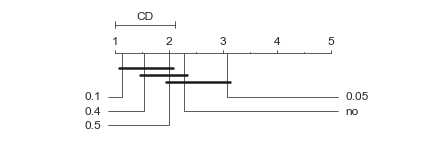

=======top_bottom_k_deterministic==========
[22 30 28 34 36]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.93333333 1.06666667 2.26666667 2.4        2.33333333]


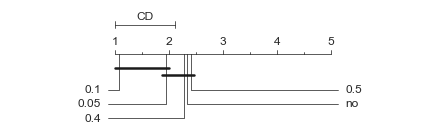

=======top_bottom_k_random==========
[37 26 34 27 26]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.8        1.93333333 1.73333333 0.93333333 2.6       ]


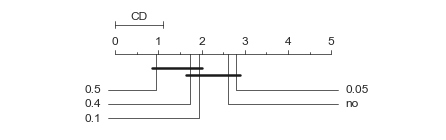

=======top_k==========
[39 34 22 26 29]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.8        1.93333333 1.8        1.26666667 2.2       ]


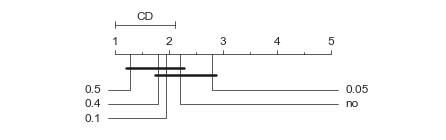

=======top_k_random==========
[22 30 19 31 48]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.73333333 1.46666667 1.93333333 1.26666667 3.6       ]


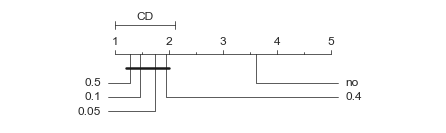

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = qualified_nodes
--------for bottom_k_deterministic----
stat=14.453, p=0.006
Probably different distributions
--------for bottom_k_random----
stat=24.480, p=0.000
Probably different distributions
--------for shared_nodes_random----
stat=25.013, p=0.000
Probably different distributions
--------for top_bottom_k_deterministic----
stat=27.413, p=0.000
Probably different distributions
--------for top_bottom_k_random----
stat=32.320, p=0.000
Probably different distributions
--------for top_k----
stat=10.720, p=0.030
Probably different distributions
--------for top_k_random----
stat=23.093, p=0.000
Probably different distributions
group = strategy and block = qualified_nodes
=======bottom_k_deterministic==========
[28 34 35 30 23]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges

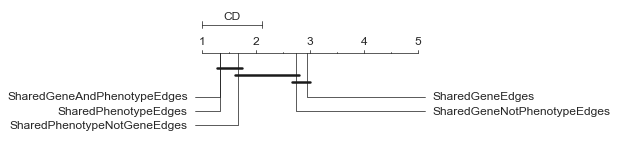

=======bottom_k_random==========
[22 33 35 31 29]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[0.8        2.46666667 3.46666667 1.66666667 1.6       ]


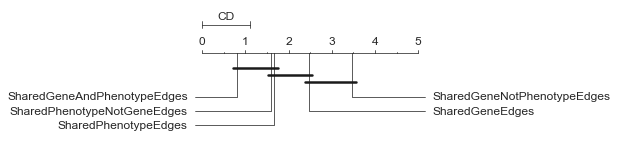

=======shared_nodes_random==========
[46 42 24 23 15]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.4        3.26666667 2.4        1.2        0.73333333]


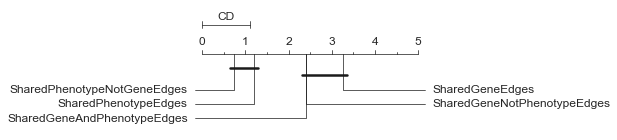

=======top_bottom_k_deterministic==========
[38 13 44 30 25]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.         2.86666667 3.4        1.2        1.53333333]


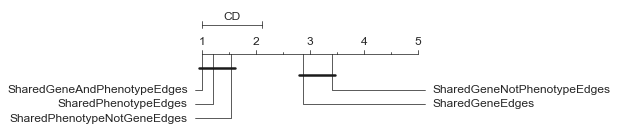

=======top_bottom_k_random==========
[32 32 21 31 34]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.13333333 2.53333333 3.53333333 0.6        2.2       ]


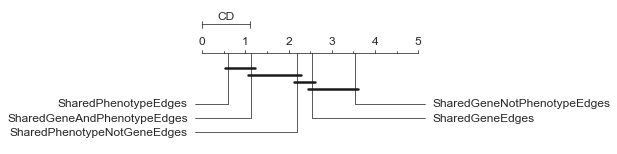

=======top_k==========
[33 34 27 23 33]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.4        2.93333333 2.         2.33333333 1.33333333]


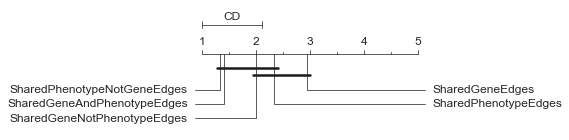

=======top_k_random==========
[36 38 25 26 25]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.33333333 3.4        2.66666667 1.4        1.2       ]


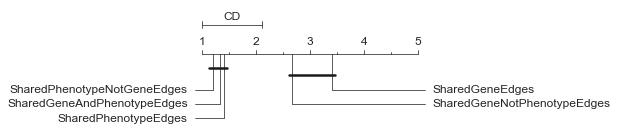

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = qualified_nodes
--------for bottom_k_deterministic----
stat=10.667, p=0.031
Probably different distributions
--------for bottom_k_random----
stat=13.973, p=0.007
Probably different distributions
--------for shared_nodes_random----
stat=9.600, p=0.048
Probably different distributions
--------for top_bottom_k_deterministic----
stat=5.067, p=0.281
Probably the same distribution
--------for top_bottom_k_random----
stat=0.480, p=0.975
Probably the same distribution
--------for top_k----
stat=7.413, p=0.116
Probably the same distribution
--------for top_k_random----
stat=4.640, p=0.326
Probably the same distribution
group = strategy and block = qualified_nodes
=======bottom_k_deterministic==========
[20 32 31 32 35]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.86666667 1.6

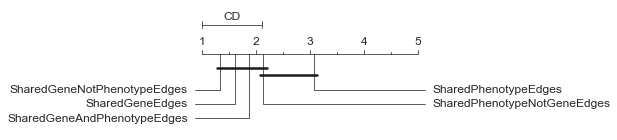

=======bottom_k_random==========
[15 28 28 38 41]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.4        1.         2.26666667 2.73333333 2.6       ]


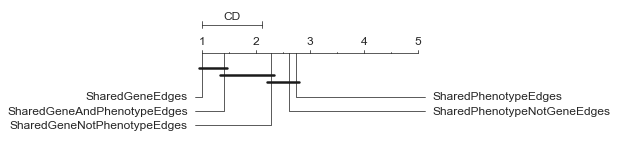

=======shared_nodes_random==========
[26 24 27 36 37]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[0.93333333 2.53333333 2.         2.4        2.13333333]


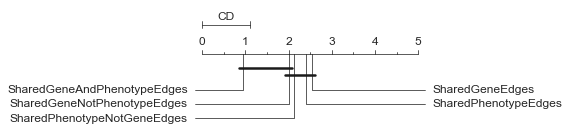

=======top_bottom_k_deterministic==========
[21 31 29 38 31]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.06666667 1.26666667 2.         2.13333333 2.53333333]


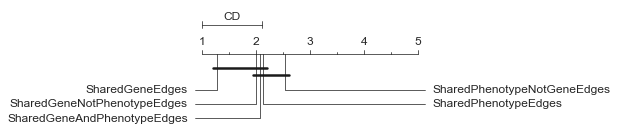

=======top_bottom_k_random==========
[29 38 21 35 27]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.06666667 2.2        1.86666667 1.86666667 2.        ]


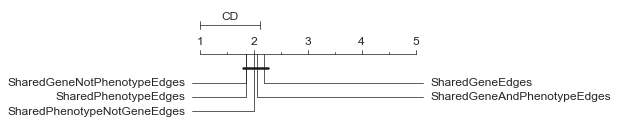

=======top_k==========
[32 37 37 31 13]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.73333333 1.86666667 2.2        2.         1.2       ]


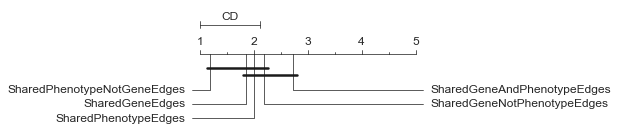

=======top_k_random==========
[24 31 22 34 39]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.73333333 1.6        1.73333333 2.6        2.33333333]


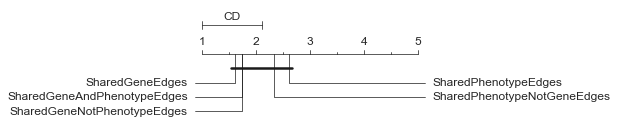

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=strategy, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = graph_type
--------for bottom_k_deterministic----
stat=5.840, p=0.054
Probably the same distribution
--------for bottom_k_random----
stat=11.520, p=0.003
Probably different distributions
--------for shared_nodes_random----
stat=5.360, p=0.069
Probably the same distribution
--------for top_bottom_k_deterministic----
stat=15.680, p=0.000
Probably different distributions
--------for top_bottom_k_random----
stat=6.320, p=0.042
Probably different distributions
--------for top_k----
stat=4.560, p=0.102
Probably the same distribution
--------for top_k_random----
stat=6.720, p=0.035
Probably different distributions
group = strategy and block = graph_type
=======bottom_k_deterministic==========
[30 25 20]
['GD', 'PGD', 'PGDP']
[1.36 0.68 0.96]


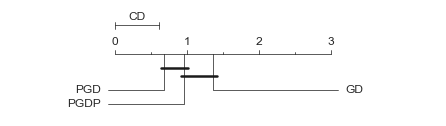

=======bottom_k_random==========
[41 17 17]
['GD', 'PGD', 'PGDP']
[1.48 1.   0.52]


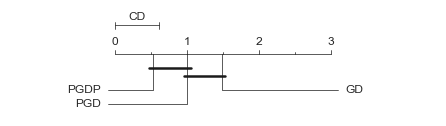

=======shared_nodes_random==========
[36 19 20]
['GD', 'PGD', 'PGDP']
[1.36 0.92 0.72]


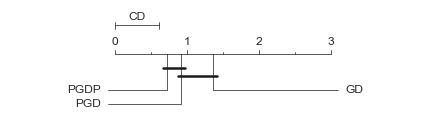

=======top_bottom_k_deterministic==========
[41 21 13]
['GD', 'PGD', 'PGDP']
[1.56 1.   0.44]


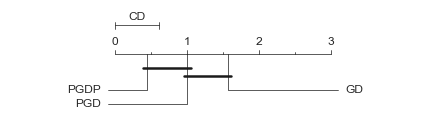

=======top_bottom_k_random==========
[31 26 18]
['GD', 'PGD', 'PGDP']
[1.4  0.72 0.88]


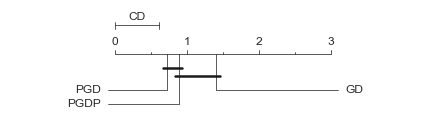

=======top_k==========
[40 10 25]
['GD', 'PGD', 'PGDP']
[1.32 0.96 0.72]


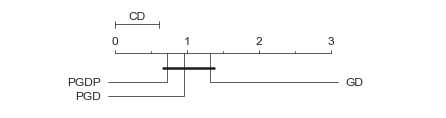

=======top_k_random==========
[36 15 24]
['GD', 'PGD', 'PGDP']
[1.4  0.68 0.92]


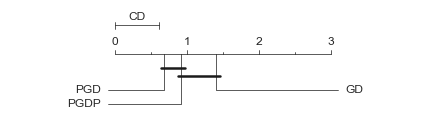

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = graph_type
--------for bottom_k_deterministic----
stat=9.680, p=0.008
Probably different distributions
--------for bottom_k_random----
stat=8.720, p=0.013
Probably different distributions
--------for shared_nodes_random----
stat=2.960, p=0.228
Probably the same distribution
--------for top_bottom_k_deterministic----
stat=3.440, p=0.179
Probably the same distribution
--------for top_bottom_k_random----
stat=18.960, p=0.000
Probably different distributions
--------for top_k----
stat=7.760, p=0.021
Probably different distributions
--------for top_k_random----
stat=13.760, p=0.001
Probably different distributions
group = strategy and block = graph_type
=======bottom_k_deterministic==========
[41 15 19]
['GD', 'PGD', 'PGDP']
[1.44 1.   0.56]


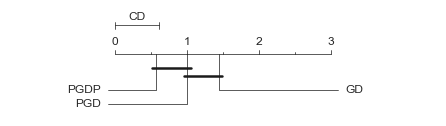

=======bottom_k_random==========
[36 20 19]
['GD', 'PGD', 'PGDP']
[1.48 0.72 0.8 ]


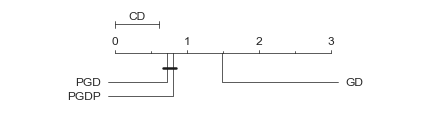

=======shared_nodes_random==========
[36 14 25]
['GD', 'PGD', 'PGDP']
[1.28 0.88 0.84]


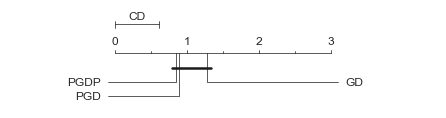

=======top_bottom_k_deterministic==========
[32 19 24]
['GD', 'PGD', 'PGDP']
[1.28 0.76 0.96]


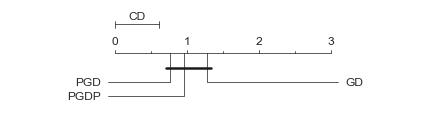

=======top_bottom_k_random==========
[29 26 20]
['GD', 'PGD', 'PGDP']
[1.52 0.32 1.16]


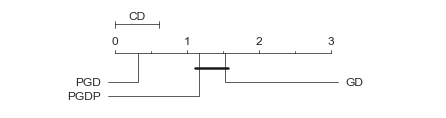

=======top_k==========
[40 14 21]
['GD', 'PGD', 'PGDP']
[1.44 0.88 0.68]


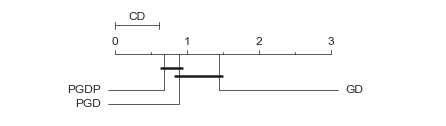

=======top_k_random==========
[34 23 18]
['GD', 'PGD', 'PGDP']
[1.56 0.52 0.92]


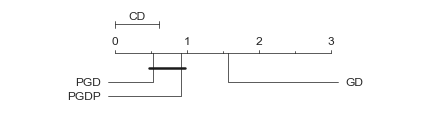

In [2600]:
# here
embedding_types = ['Node2Vec', 'GCN']
group = 'strategy'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
                run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
            run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = th
--------for bottom_k_deterministic----
stat=18.373, p=0.001
Probably different distributions
--------for bottom_k_random----
stat=11.067, p=0.026
Probably different distributions
--------for shared_nodes_random----
stat=8.080, p=0.089
Probably the same distribution
--------for top_bottom_k_deterministic----
stat=17.013, p=0.002
Probably different distributions
--------for top_bottom_k_random----
stat=15.067, p=0.005
Probably different distributions
--------for top_k----
stat=12.667, p=0.013
Probably different distributions
--------for top_k_random----
stat=17.840, p=0.001
Probably different distributions
group = strategy and block = th
=======bottom_k_deterministic==========
[41 46 65 91 57]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.06666667 1.06666667 1.83333333 2.3        2.73333333]


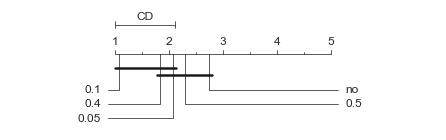

=======bottom_k_random==========
[43 67 63 58 69]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.33333333 2.3        1.86666667 2.6        1.9       ]


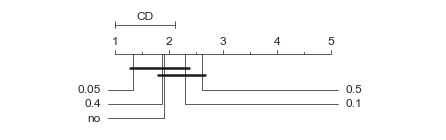

=======shared_nodes_random==========
[67 34 73 67 59]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.3        1.53333333 1.6        2.43333333 2.13333333]


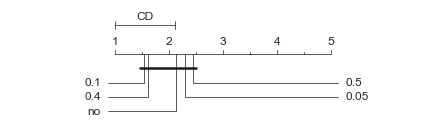

=======top_bottom_k_deterministic==========
[44 49 56 75 76]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.63333333 1.16666667 2.4        2.16666667 2.63333333]


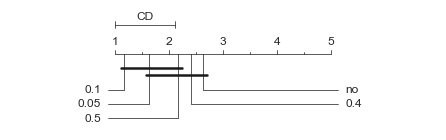

=======top_bottom_k_random==========
[56 59 62 56 67]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.2        1.83333333 1.9        1.26666667 2.8       ]


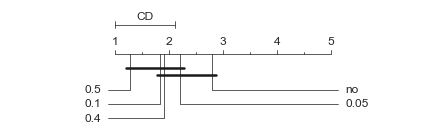

=======top_k==========
[55 52 53 59 81]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.93333333 1.66666667 1.8        1.7        2.9       ]


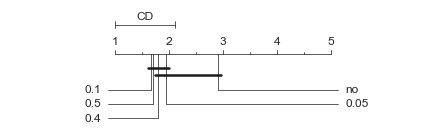

=======top_k_random==========
[46 57 44 63 90]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.56666667 1.66666667 1.9        1.8        3.06666667]


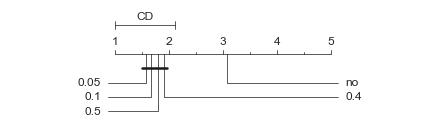

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = qualified_nodes
--------for bottom_k_deterministic----
stat=3.387, p=0.495
Probably the same distribution
--------for bottom_k_random----
stat=20.187, p=0.000
Probably different distributions
--------for shared_nodes_random----
stat=15.867, p=0.003
Probably different distributions
--------for top_bottom_k_deterministic----
stat=9.893, p=0.042
Probably different distributions
--------for top_bottom_k_random----
stat=16.587, p=0.002
Probably different distributions
--------for top_k----
stat=8.880, p=0.064
Probably the same distribution
--------for top_k_random----
stat=6.747, p=0.150
Probably the same distribution
group = strategy and block = qualified_nodes
=======bottom_k_deterministic==========
[48 66 66 62 58]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.6        

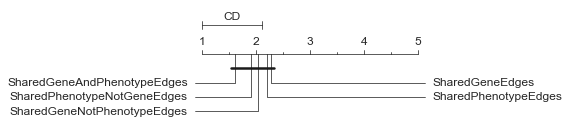

=======bottom_k_random==========
[37 61 63 69 70]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.1        1.73333333 2.86666667 2.2        2.1       ]


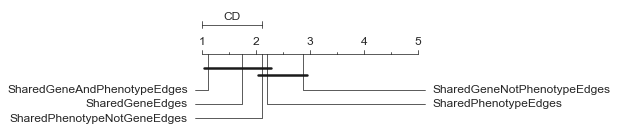

=======shared_nodes_random==========
[72 66 51 59 52]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.66666667 2.9        2.2        1.8        1.43333333]


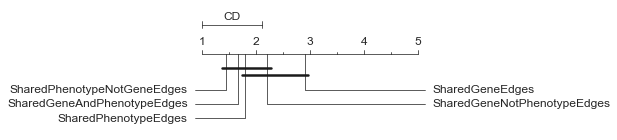

=======top_bottom_k_deterministic==========
[59 44 73 68 56]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.53333333 2.06666667 2.7        1.66666667 2.03333333]


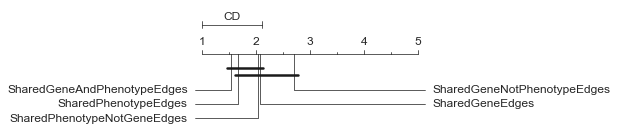

=======top_bottom_k_random==========
[61 70 42 66 61]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.6        2.36666667 2.7        1.23333333 2.1       ]


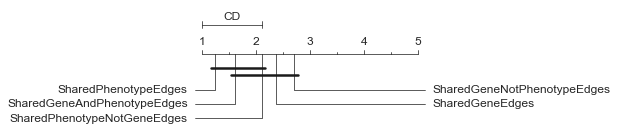

=======top_k==========
[65 71 64 54 46]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.06666667 2.4        2.1        2.16666667 1.26666667]


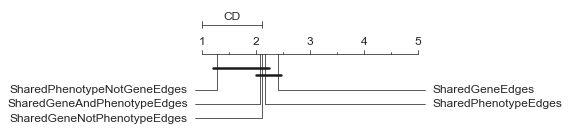

=======top_k_random==========
[60 69 47 60 64]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.53333333 2.5        2.2        2.         1.76666667]


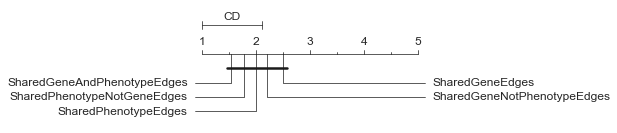

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=embedding)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = embedding
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = strategy and block = embedding
=======bottom_k_deterministic==========
[39 36]
['GCN', 'Node2Vec']
[0.52 0.48]


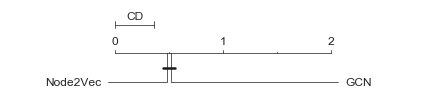

=======bottom_k_random==========
[31 44]
['GCN', 'Node2Vec']
[0.41333333 0.58666667]


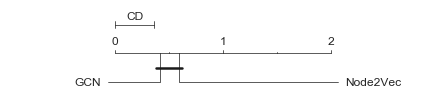

=======shared_nodes_random==========
[27 48]
['GCN', 'Node2Vec']
[0.36 0.64]


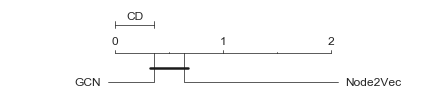

=======top_bottom_k_deterministic==========
[29 46]
['GCN', 'Node2Vec']
[0.38666667 0.61333333]


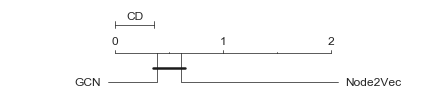

=======top_bottom_k_random==========
[35 40]
['GCN', 'Node2Vec']
[0.46666667 0.53333333]


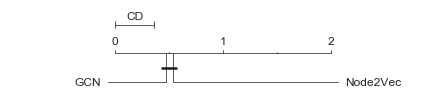

=======top_k==========
[44 31]
['GCN', 'Node2Vec']
[0.58666667 0.41333333]


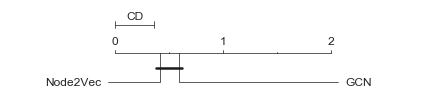

=======top_k_random==========
[31 44]
['GCN', 'Node2Vec']
[0.41333333 0.58666667]


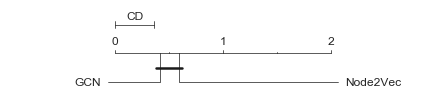

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=strategy, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = strategy and block = graph_type
--------for bottom_k_deterministic----
stat=12.160, p=0.002
Probably different distributions
--------for bottom_k_random----
stat=18.280, p=0.000
Probably different distributions
--------for shared_nodes_random----
stat=8.040, p=0.018
Probably different distributions
--------for top_bottom_k_deterministic----
stat=14.040, p=0.001
Probably different distributions
--------for top_bottom_k_random----
stat=22.120, p=0.000
Probably different distributions
--------for top_k----
stat=12.040, p=0.002
Probably different distributions
--------for top_k_random----
stat=19.840, p=0.000
Probably different distributions
group = strategy and block = graph_type
=======bottom_k_deterministic==========
[71 40 39]
['GD', 'PGD', 'PGDP']
[1.4  0.84 0.76]


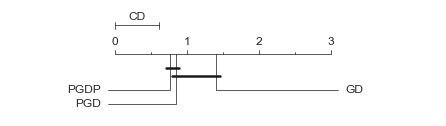

=======bottom_k_random==========
[77 37 36]
['GD', 'PGD', 'PGDP']
[1.48 0.86 0.66]


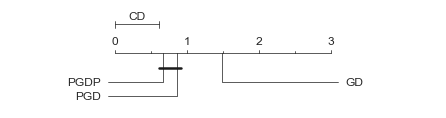

=======shared_nodes_random==========
[72 33 45]
['GD', 'PGD', 'PGDP']
[1.32 0.9  0.78]


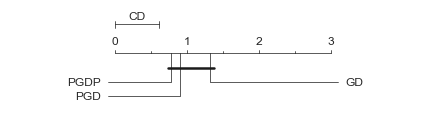

=======top_bottom_k_deterministic==========
[73 40 37]
['GD', 'PGD', 'PGDP']
[1.42 0.88 0.7 ]


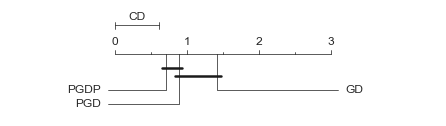

=======top_bottom_k_random==========
[60 52 38]
['GD', 'PGD', 'PGDP']
[1.46 0.52 1.02]


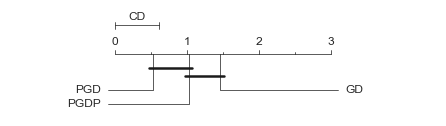

=======top_k==========
[80 24 46]
['GD', 'PGD', 'PGDP']
[1.38 0.92 0.7 ]


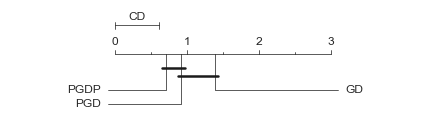

=======top_k_random==========
[70 38 42]
['GD', 'PGD', 'PGDP']
[1.48 0.6  0.92]


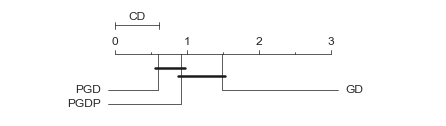

In [2601]:
group = 'strategy'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )
            

### Embedding

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=embedding, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = th
--------for Node2Vec----
stat=44.617, p=0.000
Probably different distributions
group = embedding and block = th
=======Node2Vec==========
[158 161 200 244 287]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.4        1.63809524 1.97142857 2.2952381  2.6952381 ]


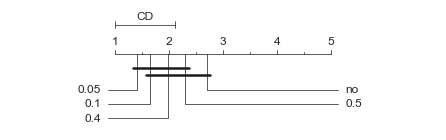

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = th
--------for GCN----
stat=25.669, p=0.000
Probably different distributions
group = embedding and block = th
=======GCN==========
[194 203 216 225 212]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.32380952 1.57142857 1.82857143 1.78095238 2.4952381 ]


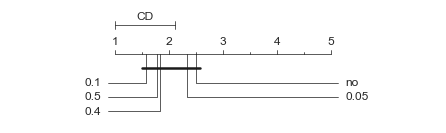

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=embedding, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = qualified_nodes
--------for Node2Vec----
stat=113.745, p=0.000
Probably different distributions
group = embedding and block = qualified_nodes
=======Node2Vec==========
[235 226 211 194 184]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.34285714 2.91428571 2.88571429 1.39047619 1.46666667]


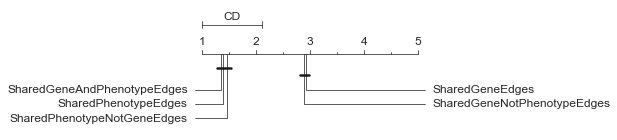

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = qualified_nodes
--------for GCN----
stat=12.213, p=0.016
Probably different distributions
group = embedding and block = qualified_nodes
=======GCN==========
[167 221 195 244 223]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.82857143 1.72380952 1.91428571 2.4        2.13333333]


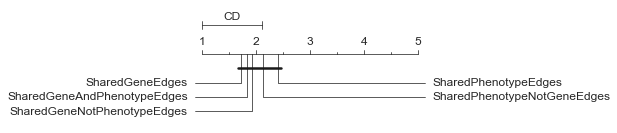

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=embedding, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = strategy
--------for Node2Vec----
stat=28.543, p=0.000
Probably different distributions
group = embedding and block = strategy
=======Node2Vec==========
[205 232 206 235 239 220 238]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.4        3.24       3.08       3.48       3.02666667 2.14666667
 3.62666667]


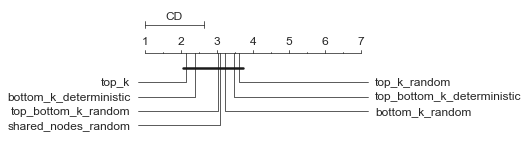

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = strategy
--------for GCN----
stat=6.377, p=0.382
Probably the same distribution
group = embedding and block = strategy
=======GCN==========
[196 239 239 195 226 235 245]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.02666667 2.77333333 2.70666667 3.12       2.82666667 3.45333333
 3.09333333]


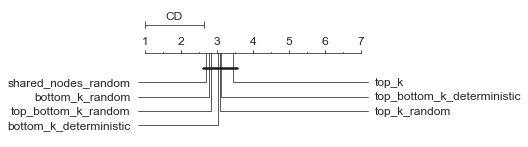

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=embedding, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = graph_type
--------for Node2Vec----
stat=45.577, p=0.000
Probably different distributions
group = embedding and block = graph_type
=======Node2Vec==========
[255 133 137]
['GD', 'PGD', 'PGDP']
[1.41142857 0.85142857 0.73714286]


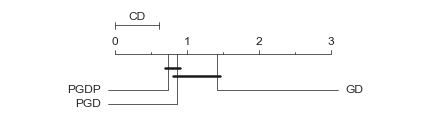

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = graph_type
--------for GCN----
stat=49.474, p=0.000
Probably different distributions
group = embedding and block = graph_type
=======GCN==========
[248 131 146]
['GD', 'PGD', 'PGDP']
[1.42857143 0.72571429 0.84571429]


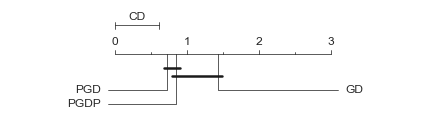

In [2602]:

embedding_types = ['Node2Vec', 'GCN']
group = 'embedding'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
                run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
            run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = th
--------for GCN----
stat=25.669, p=0.000
Probably different distributions
--------for Node2Vec----
stat=44.617, p=0.000
Probably different distributions
group = embedding and block = th
=======GCN==========
[194 203 216 225 212]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.32380952 1.57142857 1.82857143 1.78095238 2.4952381 ]


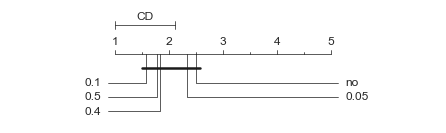

=======Node2Vec==========
[158 161 200 244 287]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.4        1.63809524 1.97142857 2.2952381  2.6952381 ]


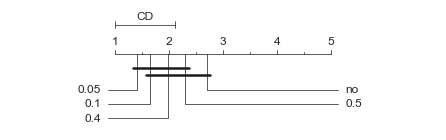

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = qualified_nodes
--------for GCN----
stat=12.213, p=0.016
Probably different distributions
--------for Node2Vec----
stat=113.745, p=0.000
Probably different distributions
group = embedding and block = qualified_nodes
=======GCN==========
[167 221 195 244 223]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.82857143 1.72380952 1.91428571 2.4        2.13333333]


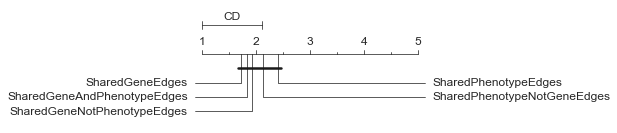

=======Node2Vec==========
[235 226 211 194 184]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.34285714 2.91428571 2.88571429 1.39047619 1.46666667]


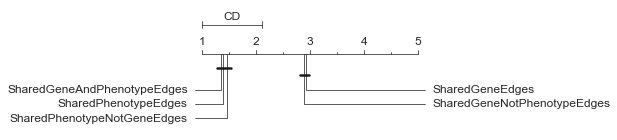

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = strategy
--------for GCN----
stat=6.377, p=0.382
Probably the same distribution
--------for Node2Vec----
stat=28.543, p=0.000
Probably different distributions
group = embedding and block = strategy
=======GCN==========
[196 239 239 195 226 235 245]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.02666667 2.77333333 2.70666667 3.12       2.82666667 3.45333333
 3.09333333]


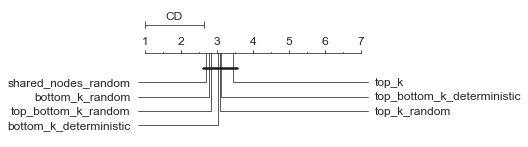

=======Node2Vec==========
[205 232 206 235 239 220 238]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.4        3.24       3.08       3.48       3.02666667 2.14666667
 3.62666667]


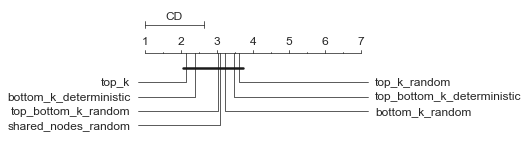

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=embedding, block=graph_type)>>>>>>>>>>>>>>>>>>>>>>
group = embedding and block = graph_type
--------for GCN----
stat=49.474, p=0.000
Probably different distributions
--------for Node2Vec----
stat=45.577, p=0.000
Probably different distributions
group = embedding and block = graph_type
=======GCN==========
[248 131 146]
['GD', 'PGD', 'PGDP']
[1.42857143 0.72571429 0.84571429]


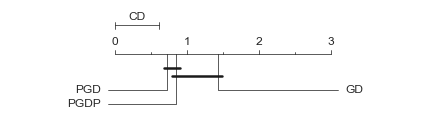

=======Node2Vec==========
[255 133 137]
['GD', 'PGD', 'PGDP']
[1.41142857 0.85142857 0.73714286]


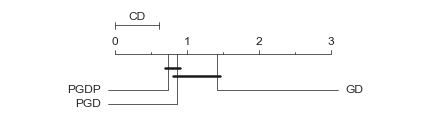

In [2603]:
group = 'embedding'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )
            

### Graph_types

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = th
--------for GD----
stat=25.669, p=0.000
Probably different distributions
--------for PGD----
stat=10.446, p=0.034
Probably different distributions
--------for PGDP----
stat=26.126, p=0.000
Probably different distributions
group = graph_type and block = th
=======GD==========
[ 53  40  67  86 104]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.14285714 1.68571429 1.82857143 2.48571429 2.85714286]


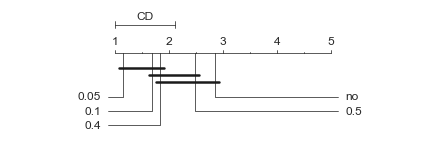

=======PGD==========
[57 64 58 78 93]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.65714286 1.68571429 1.71428571 2.42857143 2.51428571]


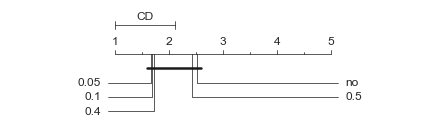

=======PGDP==========
[41 54 67 93 95]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.08571429 1.68571429 2.11428571 2.17142857 2.94285714]


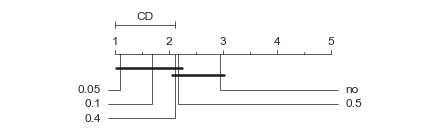

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = th
--------for GD----
stat=13.554, p=0.009
Probably different distributions
--------for PGD----
stat=9.874, p=0.043
Probably different distributions
--------for PGDP----
stat=10.286, p=0.036
Probably different distributions
group = graph_type and block = th
=======GD==========
[70 64 52 79 85]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.22857143 1.6        1.57142857 1.85714286 2.74285714]


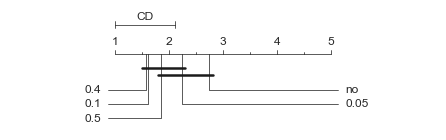

=======PGD==========
[66 65 67 77 75]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.25714286 1.57142857 1.82857143 1.74285714 2.6       ]


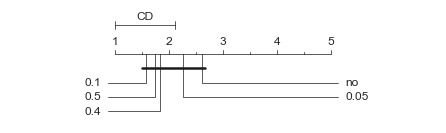

=======PGDP==========
[57 69 84 64 76]
['0.05', '0.1', '0.4', '0.5', 'no']
[2.25714286 1.51428571 1.85714286 1.77142857 2.6       ]


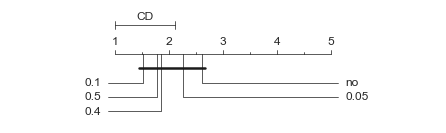

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = qualified_nodes
--------for GD----
stat=68.183, p=0.000
Probably different distributions
--------for PGD----
stat=38.217, p=0.000
Probably different distributions
--------for PGDP----
stat=36.023, p=0.000
Probably different distributions
group = graph_type and block = qualified_nodes
=======GD==========
[83 69 79 68 51]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.11428571 3.37142857 3.02857143 1.22857143 1.25714286]


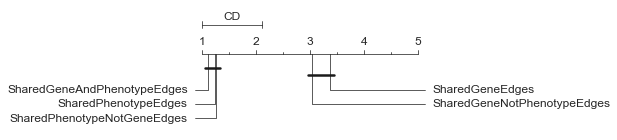

=======PGD==========
[83 74 74 61 58]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.57142857 2.82857143 2.94285714 1.14285714 1.51428571]


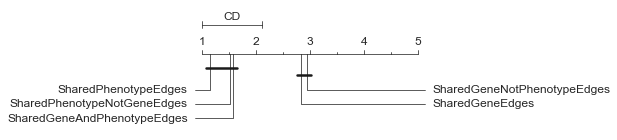

=======PGDP==========
[61 81 71 73 64]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.02857143 2.91428571 2.74285714 1.71428571 1.6       ]


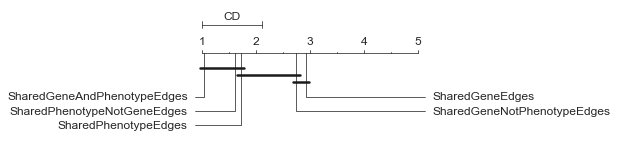

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = qualified_nodes
--------for GD----
stat=4.823, p=0.306
Probably the same distribution
--------for PGD----
stat=3.131, p=0.536
Probably the same distribution
--------for PGDP----
stat=6.423, p=0.170
Probably the same distribution
group = graph_type and block = qualified_nodes
=======GD==========
[53 60 84 79 74]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.71428571 1.71428571 1.97142857 2.31428571 2.28571429]


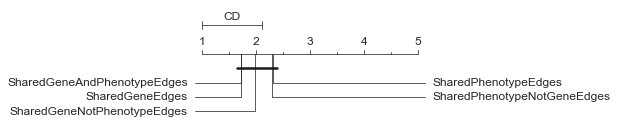

=======PGD==========
[55 72 77 76 70]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.65714286 1.94285714 2.14285714 2.28571429 1.97142857]


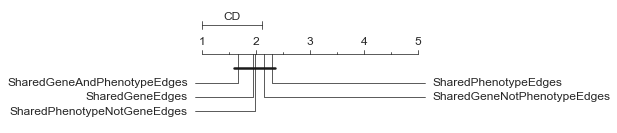

=======PGDP==========
[64 69 53 89 75]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[2.02857143 1.71428571 1.6        2.34285714 2.31428571]


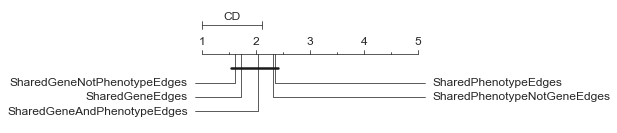

>>>>>>>>>>>>>>>>>>>>>>(embedding=Node2Vec, gruop=graph_type, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = strategy
--------for GD----
stat=19.440, p=0.003
Probably different distributions
--------for PGD----
stat=16.337, p=0.012
Probably different distributions
--------for PGDP----
stat=12.394, p=0.054
Probably the same distribution
group = graph_type and block = strategy
=======GD==========
[73 70 73 58 79 84 88]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[1.84 3.32 3.2  3.76 3.04 2.04 3.8 ]


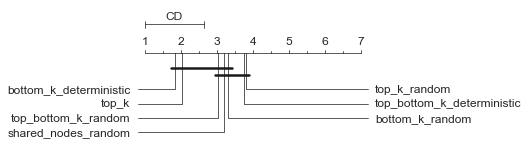

=======PGD==========
[54 93 72 69 91 71 75]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.   3.48 3.04 4.04 2.76 2.28 3.4 ]


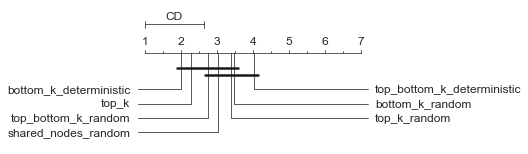

=======PGDP==========
[74 64 68 85 68 77 89]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.6  2.8  3.16 2.92 3.56 2.04 3.92]


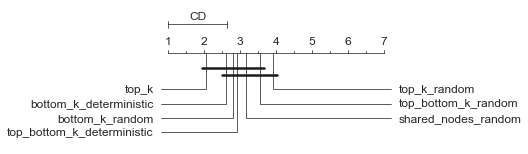

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = strategy
--------for GD----
stat=8.160, p=0.227
Probably the same distribution
--------for PGD----
stat=3.977, p=0.680
Probably the same distribution
--------for PGDP----
stat=5.897, p=0.435
Probably the same distribution
group = graph_type and block = strategy
=======GD==========
[59 86 64 73 84 71 88]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.2  2.28 2.64 3.28 2.6  3.72 3.28]


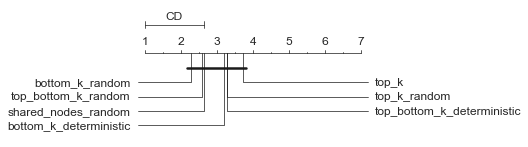

=======PGD==========
[61 95 69 74 75 70 81]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[3.24 2.56 3.12 2.96 2.6  3.56 2.96]


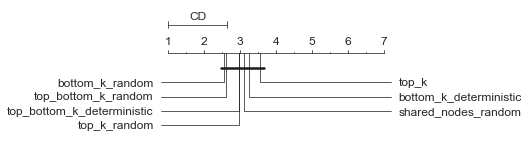

=======PGDP==========
[62 68 90 55 78 92 80]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.84 2.76 2.2  3.36 3.2  3.28 3.36]


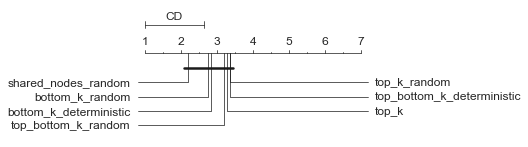

In [2550]:

embedding_types = ['Node2Vec', 'GCN']
group = 'graph_type'

for i in block_list:
    for j in embedding_types:
        if i != group and i!='embedding':
            print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
            try:
                run_friedman_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i)
            except:
                print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
            run_nemenyi_test(test_all_record_8[test_all_record_8['embedding'] == j], group, i )
            

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=th)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = th
--------for GD----
stat=10.891, p=0.028
Probably different distributions
--------for PGD----
stat=14.274, p=0.006
Probably different distributions
--------for PGDP----
stat=24.194, p=0.000
Probably different distributions
group = graph_type and block = th
=======GD==========
[131 112 140 157 160]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.95714286 1.58571429 1.94285714 2.05714286 2.45714286]


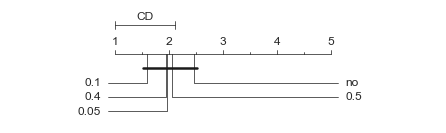

=======PGD==========
[123 129 125 155 168]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.95714286 1.62857143 1.77142857 2.08571429 2.55714286]


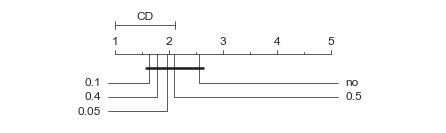

=======PGDP==========
[ 98 123 151 157 171]
['0.05', '0.1', '0.4', '0.5', 'no']
[1.67142857 1.6        1.98571429 1.97142857 2.77142857]


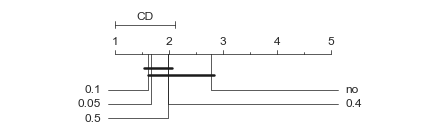

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=qualified_nodes)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = qualified_nodes
--------for GD----
stat=15.234, p=0.004
Probably different distributions
--------for PGD----
stat=20.720, p=0.000
Probably different distributions
--------for PGDP----
stat=9.886, p=0.042
Probably different distributions
group = graph_type and block = qualified_nodes
=======GD==========
[139 151 131 139 140]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.61428571 2.25714286 2.48571429 1.94285714 1.7       ]


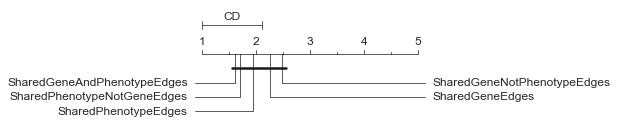

=======PGD==========
[138 146 151 137 128]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.61428571 2.38571429 2.54285714 1.71428571 1.74285714]


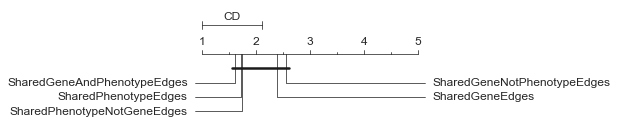

=======PGDP==========
[125 150 124 162 139]
['SharedGeneAndPhenotypeEdges', 'SharedGeneEdges', 'SharedGeneNotPhenotypeEdges', 'SharedPhenotypeEdges', 'SharedPhenotypeNotGeneEdges']
[1.52857143 2.31428571 2.17142857 2.02857143 1.95714286]


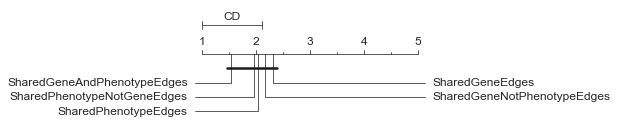

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=strategy)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = strategy
--------for GD----
stat=3.651, p=0.724
Probably the same distribution
--------for PGD----
stat=5.811, p=0.445
Probably the same distribution
--------for PGDP----
stat=9.840, p=0.132
Probably the same distribution
group = graph_type and block = strategy
=======GD==========
[150 151 146 147 153 145 158]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.8  3.22 2.92 3.26 2.72 2.82 3.26]


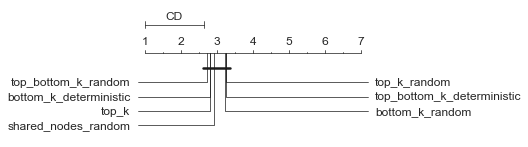

=======PGD==========
[115 188 141 143 166 141 156]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.62 3.02 3.08 3.5  2.68 2.92 3.18]


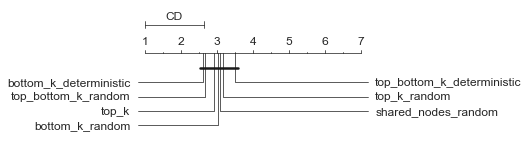

=======PGDP==========
[136 132 158 140 146 169 169]
['bottom_k_deterministic', 'bottom_k_random', 'shared_nodes_random', 'top_bottom_k_deterministic', 'top_bottom_k_random', 'top_k', 'top_k_random']
[2.72 2.78 2.68 3.14 3.38 2.66 3.64]


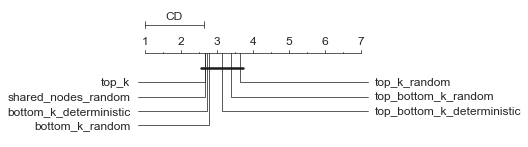

>>>>>>>>>>>>>>>>>>>>>>(embedding=GCN, gruop=graph_type, block=embedding)>>>>>>>>>>>>>>>>>>>>>>
group = graph_type and block = embedding
$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4
group = graph_type and block = embedding
=======GD==========
[78 97]
['GCN', 'Node2Vec']
[0.44571429 0.55428571]


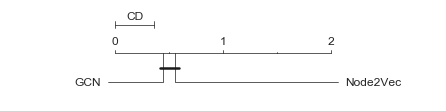

=======PGD==========
[76 99]
['GCN', 'Node2Vec']
[0.43428571 0.56571429]


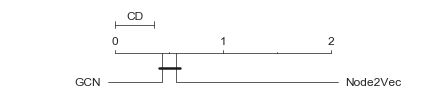

=======PGDP==========
[82 93]
['GCN', 'Node2Vec']
[0.46857143 0.53142857]


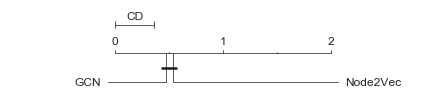

In [2604]:
group = 'graph_type'

for i in block_list:
    if i != group:
        print(f'>>>>>>>>>>>>>>>>>>>>>>(embedding={j}, gruop={group}, block={i})>>>>>>>>>>>>>>>>>>>>>>')
        try:
            run_friedman_test(test_all_record_8, group, i)
        except:
            print('$$$$$$$$$$$$$$$$$$$$$$$$$$4Failed friedman condition $$$$$$$$$$$$$$$$$$$$$$$$$$4')
        run_nemenyi_test(test_all_record_8, group, i )
            

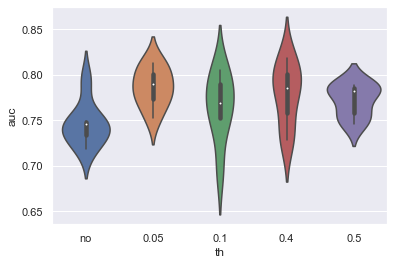

In [2611]:
# run_nemenyi_test(test_all_record_8[(test_all_record_8['embedding'] == 'Node2Vec') & (test_all_record_8['graph_type'] == 'GD') &(test_all_record_8['qualified_nodes'] == 'node2vec')], 'th', 'strategy' )
sns.violinplot(x='th', y='auc' ,sharey=True,
               data=test_all_record_8[(test_all_record_8['embedding'] == 'Node2Vec') & (test_all_record_8['graph_type'] == 'GD') &(test_all_record_8['qualified_nodes'] == 'SharedGeneEdges')])

[Text(0, 0, 'bottom_k_deterministic'),
 Text(0, 0, 'bottom_k_random'),
 Text(0, 0, 'shared_nodes_random'),
 Text(0, 0, 'top_bottom_k_deterministic'),
 Text(0, 0, 'top_bottom_k_random'),
 Text(0, 0, 'top_k'),
 Text(0, 0, 'top_k_random')]

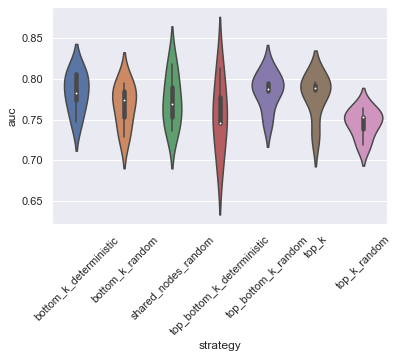

In [2614]:
# run_nemenyi_test(test_all_record_8[(test_all_record_8['embedding'] == 'Node2Vec') & (test_all_record_8['graph_type'] == 'GD') &(test_all_record_8['qualified_nodes'] == 'node2vec')], 'th', 'strategy' )
ax = sns.violinplot(x='strategy', y='auc' ,sharey=True,
               data=test_all_record_8[(test_all_record_8['embedding'] == 'Node2Vec') & (test_all_record_8['graph_type'] == 'GD') &(test_all_record_8['qualified_nodes'] == 'SharedGeneEdges')])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)